In [80]:
import ROOT
from ROOT import gROOT, TString
from ROOT import TCanvas, TLine, TGaxis, TGraph, gPad, TF1, TF2, kRed, TMultiGraph, TLegend, gStyle, TPaveStats, TStyle, TText, TList, TLatex, TGraphErrors, TFile, TTree
import json
import math
from array import array
import numpy as np
import pandas as pd

In [81]:
sigma_factor = (6.2*10e-3)/1.5

def HVCurrentDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    HV_top = []    
    HV_bot = []
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    noiseGammaRate = []
    deltaV_top = []
    deltaV_bot = []
    deltaV_top_err = []
    deltaV_bot_err = []
    for scanId in scanIds:
        !echo "None" >> counter.txt
        !rm counter.txt
        path = "Scans_2023/Scan_00"+str(scanId)+"/*_HV*_CAEN.root"
        !ls {path} >> counter.txt
        counter = np.loadtxt("counter.txt", dtype=str)
        if (str(scanId) == '5634') or (str(scanId) == '5630'):
            print("scanId = ", scanId)
            N = len(counter)
        else:
            N = len(counter)+1
        for i in range(1,N):
            jsonFile = open("Scans_2023/Scan_00"+str(scanId)+"/ANALYSIS/KODELE/HV"+str(i)+"/output.json")
            jsonFile = json.load(jsonFile)
            histFile  = ROOT.TFile.Open("Scans_2023/Scan_00"+str(scanId)+"/Scan00"+str(scanId)+"_HV"+str(i)+"_CAEN.root","READ")
            hist_current_bot = histFile.Get("Imon_KODELE-BOT")
            hist_current_top = histFile.Get("Imon_KODELE-TOP")
            hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
            hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
            eff.append(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
            muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
            gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
            muon_CS.append(jsonFile['output_parameters']['muonCLS'])
            gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
            muon_CM.append(jsonFile['output_parameters']['muonCMP'])
            gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
            muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
            gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
            muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
            gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
            noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
            current_bot.append(hist_current_bot.GetMean())
            current_top.append(hist_current_top.GetMean())
            HV_top.append(hist_HV_top.GetMean())
            HV_bot.append(hist_HV_bot.GetMean())
            if (scanId == '5630'):
                deltaV_top.append(0.001)
                deltaV_bot.append(0.001)
            else:
                deltaV_top.append(hist_current_top.GetMean()*1.5)
                deltaV_bot.append(hist_current_bot.GetMean()*1.5)
            deltaV_top_err.append(hist_current_top.GetMean()*6.2*10e-3)
            deltaV_bot_err.append(hist_current_bot.GetMean()*6.2*10e-3)
            histFile.Close()
    DataSet = {'HV_top': HV_top, 
               'HV_bot': HV_bot, 
               'current_top': current_top, 
               'current_bot': current_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'deltaV': (np.array(deltaV_top)*np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001))/(np.array(deltaV_top)+np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001)),
               }
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    DataSet['deltaV_err'] = DataSet['deltaV']* sigma_factor *np.sqrt( (1 + (np.sqrt(DataSet['current_top']**2 + DataSet['current_bot']**2 ) / ( DataSet['current_top']+DataSet['current_bot']  ) )**2 ) ) 
    return DataSet

In [82]:
def FeaturesDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    current_bot = []
    current_top = []
    HV_top = []
    HV_bot = []
    noiseGammaRate = []
    noiseGammaRate_err = []
    for scanId in scanIds:
        print("scanID: ", scanIds[scanId][0])
        
        direc = ""
        N = "1"
        if (int(scanIds[scanId][0])==5810) or (int(scanIds[scanId][0])==5805) or (int(scanIds[scanId][0])==5820) or (int(scanIds[scanId][0])==5826) or (int(scanIds[scanId][0])==5830) or (int(scanIds[scanId][0])==5827) or (int(scanIds[scanId][0])==5815) or (int(scanIds[scanId][0])==5811):    
            N = "7"
        if (int(scanIds[scanId][0])==5841)or (int(scanIds[scanId][0])==5838) or (int(scanIds[scanId][0])==5840):
            N = "8"
        jsonFile = open("Scans_2023/Scan_00"+str(scanIds[scanId][0])+"/ANALYSIS/KODELE/HV"+str(N)+"/output.json")
        histFile  = ROOT.TFile.Open("Scans_2023/Scan_00"+str(scanIds[scanId][0])+"/Scan00"+str(scanIds[scanId][0])+"_HV"+str(N)+"_CAEN.root","READ")
        hist_current_bot = histFile.Get("Imon_KODELE-BOT")
        hist_current_top = histFile.Get("Imon_KODELE-TOP")
        hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
        hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
        jsonFile = json.load(jsonFile)
        nTrig = jsonFile['output_parameters']['nTrig']
        eff.append(100*jsonFile['output_parameters']['efficiencyMuon_corrected'])
        eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
        muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
        gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
        muon_CS.append(jsonFile['output_parameters']['muonCLS'])
        gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
        muon_CM.append(jsonFile['output_parameters']['muonCMP'])
        gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
        muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
        gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
        muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
        gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
        noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
        noiseGammaRate_err.append(jsonFile['output_parameters']['noiseGammaRate_err'])
        current_bot.append(hist_current_bot.GetMean())
        current_top.append(hist_current_top.GetMean())
        HV_top.append(hist_HV_top.GetMean())
        HV_bot.append(hist_HV_bot.GetMean())
    DataSet = {'current_top': current_top, 
               'current_bot': current_bot,
               'HV_top': HV_top,
               'HV_bot': HV_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'noiseGammaRate_err': noiseGammaRate_err
              }
        
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    
    return DataSet

In [83]:
sigmoid1 = TF1("sigmoid1","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid1.SetParNames("Emax","Lambda","HV50")
sigmoid1.SetParameters(0.9, 0.01, 7000)
sigmoid2 = TF1("sigmoid2","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid2.SetParNames("Emax","Lambda","HV50")
sigmoid2.SetParameters(0.9, 0.01, 7000)
sigmoid3 = TF1("sigmoid3","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid3.SetParNames("Emax","Lambda","HV50")
sigmoid3.SetParameters(0.9, 0.01, 7000)
sigmoid4 = TF1("sigmoid4","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid4.SetParNames("Emax","Lambda","HV50")
sigmoid4.SetParameters(0.9, 0.01, 7000)
sigmoid5 = TF1("sigmoid5","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid5.SetParNames("Emax","Lambda","HV50")
sigmoid5.SetParameters(0.9, 0.001, 7000)
sigmoid6 = TF1("sigmoid6","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid6.SetParNames("Emax","Lambda","HV50")
sigmoid6.SetParameters(0.9, 0.01, 7000)
sigmoid7 = TF1("sigmoid7","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid7.SetParNames("Emax","Lambda","HV50")
sigmoid7.SetParameters(0.9, 0.01, 7000)
sigmoid8 = TF1("sigmoid8","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid8.SetParNames("Emax","Lambda","HV50")
sigmoid8.SetParameters(0.9, 0.01, 7000)
sigmoid9 = TF1("sigmoid9","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid9.SetParNames("Emax","Lambda","HV50")
sigmoid9.SetParameters(0.9, 0.001, 7000)
sigmoid10 = TF1("sigmoid10","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid10.SetParNames("Emax","Lambda","HV50")
sigmoid10.SetParameters(0.9, 0.01, 7000)
sigmoid11 = TF1("sigmoid11","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid11.SetParNames("Emax","Lambda","HV50")
sigmoid11.SetParameters(0.9, 0.0001, 11000)
sigmoid12 = TF1("sigmoid12","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid12.SetParNames("Emax","Lambda","HV50")
sigmoid12.SetParameters(0.9, 0.01, 7000)
sigmoid13 = TF1("sigmoid13","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid13.SetParNames("Emax","Lambda","HV50")
sigmoid13.SetParameters(0.9, 0.01, 7000)
sigmoid14 = TF1("sigmoid14","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid14.SetParNames("Emax","Lambda","HV50")
sigmoid14.SetParameters(0.9, 0.001, 7000)
sigmoid15 = TF1("sigmoid15","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid15.SetParNames("Emax","Lambda","HV50")
sigmoid15.SetParameters(0.9, 0.001, 7000)
sigmoid16 = TF1("sigmoid16","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid16.SetParNames("Emax","Lambda","HV50")
sigmoid16.SetParameters(0.9, 0.01, 7000)
sigmoid17 = TF1("sigmoid17","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid17.SetParNames("Emax","Lambda","HV50")
sigmoid17.SetParameters(0.9, 0.01, 7000)
sigmoid18 = TF1("sigmoid18","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid18.SetParNames("Emax","Lambda","HV50")
sigmoid18.SetParameters(0.9, 0.01, 7000)
sigmoid19 = TF1("sigmoid19","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid19.SetParNames("Emax","Lambda","HV50")
sigmoid19.SetParameters(0.9, 0.001, 7000)
sigmoid20 = TF1("sigmoid20","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid20.SetParNames("Emax","Lambda","HV50")
sigmoid20.SetParameters(0.9, 0.001, 7000)
sigmoid21 = TF1("sigmoid20","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid21.SetParNames("Emax","Lambda","HV50")
sigmoid21.SetParameters(0.9, 0.001, 7000)
sigmoid22 = TF1("sigmoid20","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid22.SetParNames("Emax","Lambda","HV50")
sigmoid22.SetParameters(0.9, 0.001, 7000)

In [84]:
scans = {'30CO2_OFF': ['5627'],
         '30CO2_22':  ['5659'],
         '30CO2_10':  ['5675'],
         '30CO2_6.9': ['5621'],
         '30CO2_4.6': ['5623'],
         '30CO2_3.3': ['5622', '5625'],
         '30CO2_2.2': ['5827'],
         '30CO2_1': ['5820'],
         '30CO205SF6_OFF': ['5712'],
         '30CO205SF6_22':  ['5706'],
         '30CO205SF6_10':  ['5707'],
         '30CO205SF6_6.9': ['5708'],
         '30CO205SF6_4.6': ['5709'],
         '30CO205SF6_3.3': ['5713'],
         '30CO205SF6_2.2': ['5840'],
         '30CO205SF6_1': ['5838'],
         '40CO2_OFF': ['5612'],
         '40CO2_22':  ['5615'],
         '40CO2_10':  ['5614'],
         '40CO2_6.9': ['5616'],
         '40CO2_4.6': ['5613'],
         '40CO2_3.3': ['5611'],
         'STDMX_OFF': ['5809'],
         'STDMX_22':  ['5632'],
         'STDMX_10':  ['5631'],
         'STDMX_6.9': ['5633'],
         'STDMX_4.6': ['5630'],
         'STDMX_3.3': ['5629'],
         'STDMX_2.2': ['5805'],
         'STDMX_1': ['5810']
         }

Scans_30CO2 = {'30CO2_OFF': ['5819'],
         '30CO2_22':  ['5826'],
         '30CO2_10':  ['5832'], #HV7
         '30CO2_6.9': ['5830'], #HV7
         '30CO2_4.6': ['5831'],
         '30CO2_3.3': ['5822'],
         '30CO2_2.2': ['5827'], #HV7
         '30CO2_1': ['5820'] #HV7
         }

Scans_40CO2 = {'40CO2_OFF': ['5845'],
         '40CO2_22':  ['5846'],
         '40CO2_10':  ['5844'],
         '40CO2_6.9': ['5843'],
         '40CO2_4.6': ['5842'],
         '40CO2_3.3': ['5841'] # HV8
         }

Scans_STDMX = {'STDMX_OFF': ['5808'],
         'STDMX_22':  ['5813'],
         'STDMX_10':  ['5815'], #HV7
         'STDMX_6.9': ['5811'], #HV7 
         'STDMX_4.6': ['5807'],
         'STDMX_3.3': ['5814'],
         'STDMX_2.2': ['5805'], #HV7
         'STDMX_1': ['5810'], #HV7
         }

Scans_30CO205SF6 = {'30CO205SF6_OFF': ['5833'],
         '30CO205SF6_22':  ['5839'],
         '30CO205SF6_10':  ['5836'],
         '30CO205SF6_6.9': ['5837'],
         '30CO205SF6_4.6': ['5835'],
         '30CO205SF6_3.3': ['5834'],
         '30CO205SF6_2.2': ['5838'], #HV7
         '30CO205SF6_1': ['5840']} #HV7

Scans_OFF = {'30CO205SF6_OFF': ['5833'],
            'STDMX_OFF': ['5808'], 
            '40CO2_OFF': ['5845'],
            '30CO2_OFF': ['5819'], 
         }

Scans_33 = {
          'STDMX_3.3': ['5814'],
          '30CO2_3.3': ['5822'],
          '30CO205SF6_3.3': ['5834'],
          '40CO2_3.3': ['5841'],
}
Scans_OFF = {'30CO205SF6_OFF': ['5833'],
            'STDMX_OFF': ['5808'], 
            '40CO2_OFF': ['5845'],
            '30CO2_OFF': ['5819'], 
         }
Scans_33 = {
          'STDMX_3.3': ['5814'],
          '30CO2_3.3': ['5822'],
          '30CO205SF6_3.3': ['5834'],
          '40CO2_3.3': ['5841'],
}

scans_STDMX = [
         ['STDMX_OFF', sigmoid1, 6, 23],
         ['STDMX_10', sigmoid2, 3, 22],
         ['STDMX_3.3', sigmoid3, 1, 34],
         ['STDMX_2.2', sigmoid4, 2, 20],
         ['STDMX_1', sigmoid5, 4, 21],
         ]

scans_30CO2 = [
         ['30CO2_OFF', sigmoid6, 6, 23],
         ['30CO2_10', sigmoid7, 3, 22],
         ['30CO2_3.3', sigmoid8, 1, 34],
         ['30CO2_2.2', sigmoid9, 2, 20],
         ['30CO2_1', sigmoid10, 4, 21],
         ]
scans_30CO205SF6 = [
         ['30CO205SF6_OFF', sigmoid16, 6, 23],
         ['30CO205SF6_10', sigmoid17, 3, 22],
         ['30CO205SF6_3.3', sigmoid18, 1, 34],
         ['30CO205SF6_2.2', sigmoid19, 2, 20],
         ['30CO205SF6_1', sigmoid20, 4, 21],
         ]
scans_40CO2 = [
         ['40CO2_OFF', sigmoid11, 6, 23],
         ['40CO2_10', sigmoid12, 3, 22],
         ['40CO2_6.9', sigmoid14, 2, 20],
         ['40CO2_4.6', sigmoid21, 4, 21],
         ['40CO2_3.3', sigmoid13, 1, 34],
         ]
scans_OFF = [
        ['STDMX_OFF', sigmoid1, 6, 23],
        ['30CO2_OFF', sigmoid6, 6, 23],
        ['30CO205SF6_OFF', sigmoid16, 6, 23],
        ['40CO2_OFF', sigmoid11, 6, 23],
]
scans_33 = [
        ['STDMX_3.3', sigmoid4, 2, 20],
        ['30CO2_3.3', sigmoid9, 2, 20],
        ['30CO205SF6_3.3', sigmoid19, 2, 20],
        ['40CO2_3.3', sigmoid22, 1, 34],
]
scans_OFF = [
        ['STDMX_OFF', sigmoid1, 6, 23],
        ['30CO2_OFF', sigmoid6, 6, 23],
        ['30CO205SF6_OFF', sigmoid16, 6, 23],
        ['40CO2_OFF', sigmoid11, 6, 23],
]
scans_33 = [
        ['STDMX_3.3', sigmoid4, 2, 20],
        ['30CO2_3.3', sigmoid9, 2, 20],
        ['30CO205SF6_3.3', sigmoid19, 2, 20],
        ['40CO2_3.3', sigmoid22, 1, 34],
]

In [85]:
for scan in scans:
    print(scan, ': ')
    print(HVCurrentDataFrame(scans[scan]))

30CO2_OFF : 


    HV_top  HV_bot  current_top  current_bot  muon_stream  gamma_stream  \
0   6000.0  6000.0     0.000000     0.000000     0.000000      0.000000   
1   6100.0  6100.0     0.000000     0.000000     0.000000      0.000000   
2   6200.0  6200.0     0.000000     0.000000     0.000000      0.000000   
3   6300.0  6300.0     0.000000     0.000000     0.000000      0.000000   
4   6400.0  6400.0     0.000000     0.000000     0.000487      0.000000   
5   6500.0  6500.0     0.000000     0.000000     0.000741      0.000000   
6   6600.0  6600.0     0.000000     0.000000     0.001627      0.000000   
7   6700.0  6700.0     0.000000     0.000000     0.001906      0.000000   
8   6800.0  6800.0     0.000000     0.000000     0.002213      0.000000   
9   6900.0  6900.0     0.000000     0.000000     0.006078      0.000000   
10  7000.0  7000.0     0.002920     0.000000     0.005998      0.000050   
11  7100.0  7100.0     0.006515     0.004235     0.007647      0.000000   
12  7200.0  7200.0     0.

In [86]:
Features_STDMX = FeaturesDataFrame(Scans_STDMX)
Features_STDMX['gamma_CM'][0] = 1
Features_STDMX['gamma_CS'][0] = 1
Features_STDMX['noiseGammaRate'][0] = 1
print("FeaturesDataFrame(Scans_STDMX) = ", FeaturesDataFrame(Scans_STDMX))
Features_STDMX

scanID:  5808
scanID:  5813
scanID:  5815
scanID:  5811
scanID:  5807
scanID:  5814
scanID:  5805
scanID:  5810
scanID:  5808
scanID:  5813
scanID:  5815
scanID:  5811
scanID:  5807
scanID:  5814
scanID:  5805
scanID:  5810
FeaturesDataFrame(Scans_STDMX) =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     0.662577     0.579678  7250.0  7250.0     0.021638      0.000510   
1     7.331106     6.235990  7250.0  7250.0     0.020339      0.009124   
2    12.528288    10.652905  7200.0  7200.0     0.013554      0.013070   
3    18.163424    15.603424  7200.0  7200.0     0.018294      0.017172   
4    25.579945    21.916266  7250.0  7250.0     0.020301      0.028520   
5    38.579806    33.307197  7250.0  7250.0     0.016467      0.040073   
6    45.416834    38.666666  7200.0  7200.0     0.012144      0.035533   
7    86.239032    73.963387  7200.0  7200.0     0.008774      0.050569   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0 

,current_top,current_bot,HV_top,HV_bot,muon_stream,gamma_stream,muon_CM,gamma_CM,muon_CS,gamma_CS,muon_CM_err,gamma_CM_err,muon_CS_err,gamma_CS_err,efficiency,eff_error,noiseGammaRate,noiseGammaRate_err,current
0,0.662577,0.579678,7250.0,7250.0,0.021638,0.000510,1.056347,1.000000,2.149189,1.000000,0.128334,0.049051,0.232817,0.037743,98.604936,0.000838,1.000000,2.257067,1.242255
1,7.331106,6.235990,7250.0,7250.0,0.020339,0.009124,1.077327,1.858821,2.120928,1.854984,0.120509,0.141672,0.213376,0.131367,96.817526,0.001771,252.046840,15.871513,13.567095
2,12.528288,10.652905,7200.0,7200.0,0.013554,0.013070,1.087038,2.808565,1.918211,1.726102,0.102617,0.183007,0.165461,0.105593,97.229975,0.002333,443.252216,21.047275,23.181193
3,18.163424,15.603424,7200.0,7200.0,0.018294,0.017172,1.114041,3.925548,1.886551,1.711130,0.107135,0.257984,0.165510,0.105519,96.750063,0.002524,652.265160,25.531975,33.766847
4,25.579945,21.916266,7250.0,7250.0,0.020301,0.028520,1.138434,5.301146,2.017176,1.784251,0.113382,0.372206,0.182703,0.117058,96.530672,0.001482,934.880286,30.566492,47.496211
5,38.579806,33.307197,7250.0,7250.0,0.016467,0.040073,1.190779,8.088920,1.989675,1.750194,0.114043,0.550905,0.173901,0.111598,95.672184,0.002050,1405.879286,37.484303,71.887003
6,45.416834,38.666666,7200.0,7200.0,0.012144,0.035533,1.204696,10.107134,1.750532,1.629212,0.093490,0.593147,0.126066,0.090312,94.331049,0.003283,1636.756207,40.444366,84.083500
7,86.239032,73.963387,7200.0,7200.0,0.008774,0.050569,1.339684,20.048940,1.671138,1.542672,0.080970,1.052406,0.095246,0.076939,92.809289,0.003664,3072.646371,55.412495,160.202420


Total de scans no dicionário: 5
Processando scan: STDMX_OFF
Funções no gráfico após ajuste: ['sigmoid1']
Lambda = 0.01216180708246331
HV95_err = 3.7603528229451637
Fit concluído para o scan: STDMX_OFF
Processando scan: STDMX_10
Funções no gráfico após ajuste: ['sigmoid2']
Lambda = 0.010579609411315853
HV95_err = 3.062315569430728
Fit concluído para o scan: STDMX_10
Processando scan: STDMX_3.3
Funções no gráfico após ajuste: ['sigmoid3']
Lambda = 0.01056025004644915
HV95_err = 3.4716011042430694
Fit concluído para o scan: STDMX_3.3
Processando scan: STDMX_2.2
Funções no gráfico após ajuste: ['sigmoid4']
Lambda = 0.011864636183976537
HV95_err = 4.383025771544109
Fit concluído para o scan: STDMX_2.2
Processando scan: STDMX_1
Funções no gráfico após ajuste: ['sigmoid5']
Lambda = 0.011974763187287744
HV95_err = 4.129418620077054
Fit concluído para o scan: STDMX_1
Tabela salva em 'tabela_dados_STDMX.csv'.
****************************************
Minimizer is Minuit2 / Migrad
Chi2            

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6070 xmax = 7630 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [6070.000000,7630.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5840.000000,7760.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [58

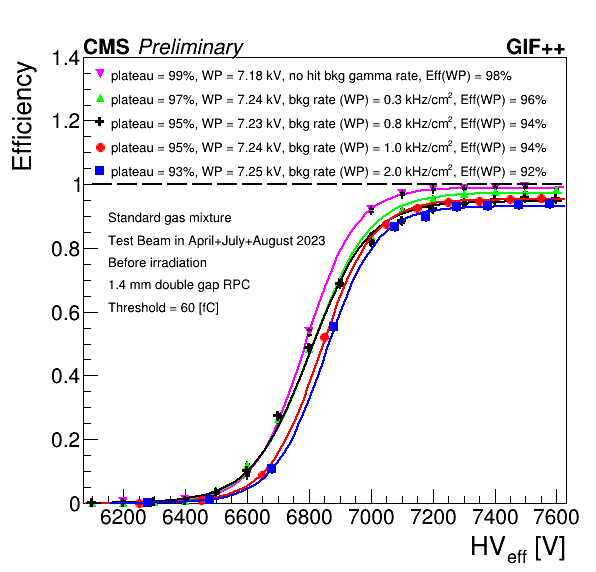

In [87]:
from ROOT import TCanvas, TGraphErrors, TLatex, TLine, TLegend
import math
import pandas as pd

# Inicializando listas para gráficos e funções
TGraphs_list_STDMX = []
func_list_STDMX = []

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

markers = [23, 22, 20, 29]
colors = [6, 3, 2, 1]  # Rosa, verde, vermelho, preto

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_STDMX)
print(f"Total de scans no dicionário: {num_scans_total}")

# Listas para armazenar os dados
tabela_dados = []

for scan, sigmoid, color, marker in scans_STDMX:
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])

    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values) # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    sig.SetLineColor(color)
    gr_E.SetMarkerColor(color)
    gr_E.SetMarkerStyle(marker)

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2) # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_STDMX.append(gr_E)
    func_list_STDMX.append(sig)
    
    # Adicionando dados à tabela
    for i in range(n):
        HV_top = df['HV_top'].values[i]
        efficiency = df['efficiency'].values[i]
        eff_error = df['eff_error'].values[i]
        tabela_dados.append([scan, HV_top, efficiency, eff_error])
    
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_STDMX:
    TGraphs_list_STDMX[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_STDMX[0].SetTitle("")
    TGraphs_list_STDMX[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_STDMX[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_STDMX[0].Draw("AP")
    
    for graph in TGraphs_list_STDMX[1:]:
        graph.Draw("PSAME")

    Emax_STDMX = []
    Emax_err_STDMX = []
    Lambda_STDMX = []
    Lambda_err_STDMX = []
    HV50_STDMX = []
    HV50_err_STDMX = []
    HV95_STDMX = []
    HV95_err_STDMX = []

    for sig in func_list_STDMX:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_STDMX.append(Emax_)
        Emax_err_STDMX.append(sig.GetParError(0))     
        Lambda_STDMX.append(sig.GetParameter(1))  
        Lambda_err_STDMX.append(sig.GetParError(1))
        HV50_STDMX.append(sig.GetParameter(2))  
        HV50_err_STDMX.append(sig.GetParError(2)) 
        HV95_STDMX.append(sig.GetX(HV_ref))
        HV95_err_STDMX.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2)) # erro HV95

    WP_STDMX = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_STDMX, Lambda_STDMX, HV50_STDMX):
        WP_STDMX.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_STDMX_10 = Features_STDMX['noiseGammaRate'][2] / (Features_STDMX['gamma_CS'][2] * 1000)
    txt_STDMX_3_3 = Features_STDMX['noiseGammaRate'][5] / (Features_STDMX['gamma_CS'][5] * 1000)
    txt_STDMX_2_2 = Features_STDMX['noiseGammaRate'][6] / (Features_STDMX['gamma_CS'][6] * 1000)
    txt_STDMX_1 = Features_STDMX['noiseGammaRate'][7] / (Features_STDMX['gamma_CS'][7] * 1000)

    eff_1_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[0], b=WP_STDMX[0] / 1000., c=(func_list_STDMX[0].Eval(WP_STDMX[0])))
    eff_2_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[1], b=WP_STDMX[1] / 1000., c=(func_list_STDMX[1].Eval(WP_STDMX[1])), d=txt_STDMX_10)
    eff_3_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[2], b=WP_STDMX[2] / 1000., c=(func_list_STDMX[2].Eval(WP_STDMX[2])), d=txt_STDMX_3_3)
    eff_4_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[3], b=WP_STDMX[3] / 1000., c=(func_list_STDMX[3].Eval(WP_STDMX[3])), d=txt_STDMX_2_2)
    eff_5_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[4], b=WP_STDMX[4] / 1000., c=(func_list_STDMX[4].Eval(WP_STDMX[4])), d=txt_STDMX_1)

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS MUON")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary")

    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 
    legend.AddEntry(TGraphs_list_STDMX[0], eff_1_STDMX, "P")
    legend.AddEntry(TGraphs_list_STDMX[1], eff_2_STDMX, "P")
    legend.AddEntry(TGraphs_list_STDMX[2], eff_3_STDMX, "P")
    if len(TGraphs_list_STDMX) > 3:
        legend.AddEntry(TGraphs_list_STDMX[3], eff_4_STDMX, "P")
    if len(TGraphs_list_STDMX) > 4:
        legend.AddEntry(TGraphs_list_STDMX[4], eff_5_STDMX, "P")
    legend.Draw()
    canvas_all.Draw()

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(5900, 0.88, "Standard gas mixture")
    ltx_data.DrawLatex(5900, 0.81, "Test Beam in April+July+August 2023")
    ltx_data.DrawLatex(5900, 0.74, "Before irradiation")
    ltx_data.DrawLatex(5900, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(5900, 0.60, "Threshold = 60 [fC]")

    line = TLine(5850, 1., 7750, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    canvas_all.cd()
    canvas_all.Draw()
else:
    print("Nenhum gráfico válido para desenhar.")

# Salvando a tabela em um arquivo CSV
tabela_df = pd.DataFrame(tabela_dados, columns=["Scan", "HV_top", "Efficiency", "Eff_Error"])
tabela_df.to_csv("tabela_dados_STDMX.csv", index=False)
print("Tabela salva em 'tabela_dados_STDMX.csv'.")

In [88]:
from ROOT import TCanvas, TGraphErrors, TLatex, TLine, TLegend
import math
import pandas as pd

# Nome do arquivo CSV original
arquivo_csv = 'tabela_dados_STDMX.csv'

# Ler o arquivo CSV
df_csv = pd.read_csv(arquivo_csv)

# Ajustar os valores de HV_top para os scans especificados
df_csv.loc[df_csv['Scan'] == 'STDMX_1', 'HV_top'] += 80
df_csv.loc[df_csv['Scan'] == 'STDMX_2.2', 'HV_top'] += 50

# Inicializando listas para gráficos e funções
TGraphs_list_STDMX = []
func_list_STDMX = []

# Configurações do canvas
canvas = TCanvas("c", "c", 564, 232, 600, 600)
canvas.SetTopMargin(0.1)
canvas.SetBottomMargin(0.12)
canvas.SetLeftMargin(0.14)
canvas.SetRightMargin(0.05)

HV_ref = 95


k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_STDMX)
print(f"Total de scans no dicionário: {num_scans_total}")

for scan, sigmoid, color, marker in scans_STDMX:
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")

    # Filtrar dados do DataFrame ajustado
    df = df_csv[df_csv['Scan'] == scan]
    n = len(df['HV_top'])

    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['Efficiency'].values,
                        0,
                        df['Eff_Error'].values) # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    sig.SetLineColor(color)
    gr_E.SetMarkerColor(color)
    gr_E.SetMarkerStyle(marker)
    gr_E.SetLineWidth(2)
    gr_E.SetMarkerSize(1.2)

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2) # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_STDMX.append(gr_E)
    func_list_STDMX.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)
canvas_all.SetTopMargin(0.1)
canvas_all.SetBottomMargin(0.12)
canvas_all.SetLeftMargin(0.14)
canvas_all.SetRightMargin(0.05)

if TGraphs_list_STDMX:
    TGraphs_list_STDMX[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_STDMX[0].GetHistogram().SetMinimum(0)
    TGraphs_list_STDMX[0].SetTitle("")
    TGraphs_list_STDMX[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_STDMX[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_STDMX[0].GetXaxis().SetTitleSize(0.05)
    TGraphs_list_STDMX[0].GetYaxis().SetTitleSize(0.05)
    TGraphs_list_STDMX[0].GetXaxis().SetLabelSize(0.04)
    TGraphs_list_STDMX[0].GetYaxis().SetLabelSize(0.04)
    TGraphs_list_STDMX[0].Draw("AP")
    
    for graph in TGraphs_list_STDMX[1:]:
        graph.Draw("PSAME")

    Emax_STDMX = []
    Emax_err_STDMX = []
    Lambda_STDMX = []
    Lambda_err_STDMX = []
    HV50_STDMX = []
    HV50_err_STDMX = []
    HV95_STDMX = []
    HV95_err_STDMX = []

    for sig in func_list_STDMX:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_STDMX.append(Emax_)
        Emax_err_STDMX.append(sig.GetParError(0))     
        Lambda_STDMX.append(sig.GetParameter(1))  
        Lambda_err_STDMX.append(sig.GetParError(1))
        HV50_STDMX.append(sig.GetParameter(2))  
        HV50_err_STDMX.append(sig.GetParError(2)) 
        HV95_STDMX.append(sig.GetX(HV_ref))
        HV95_err_STDMX.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2)) # erro HV95

    WP_STDMX = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_STDMX, Lambda_STDMX, HV50_STDMX):
        WP_STDMX.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_STDMX_10 = Features_STDMX['noiseGammaRate'][2] / (Features_STDMX['gamma_CS'][2] * 1000)
    txt_STDMX_3_3 = Features_STDMX['noiseGammaRate'][5] / (Features_STDMX['gamma_CS'][5] * 1000)
    txt_STDMX_2_2 = Features_STDMX['noiseGammaRate'][6] / (Features_STDMX['gamma_CS'][6] * 1000)
    txt_STDMX_1 = Features_STDMX['noiseGammaRate'][7] / (Features_STDMX['gamma_CS'][7] * 1000)

    eff_1_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[0], b=WP_STDMX[0] / 1000., c=(func_list_STDMX[0].Eval(WP_STDMX[0])))
    eff_2_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[1], b=WP_STDMX[1] / 1000., c=(func_list_STDMX[1].Eval(WP_STDMX[1])), d=txt_STDMX_10)
    eff_3_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[2], b=WP_STDMX[2] / 1000., c=(func_list_STDMX[2].Eval(WP_STDMX[2])), d=txt_STDMX_3_3)
    eff_4_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[3], b=WP_STDMX[3] / 1000., c=(func_list_STDMX[3].Eval(WP_STDMX[3])), d=txt_STDMX_2_2)
    eff_5_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[4], b=WP_STDMX[4] / 1000., c=(func_list_STDMX[4].Eval(WP_STDMX[4])), d=txt_STDMX_1)

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.14, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.85, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.23, 0.905, "Preliminary")

    legend = TLegend(0.15, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 
    legend.AddEntry(TGraphs_list_STDMX[0], eff_1_STDMX, "P")
    legend.AddEntry(TGraphs_list_STDMX[1], eff_2_STDMX, "P")
    legend.AddEntry(TGraphs_list_STDMX[2], eff_3_STDMX, "P")
    legend.AddEntry(TGraphs_list_STDMX[3], eff_4_STDMX, "P")
    legend.AddEntry(TGraphs_list_STDMX[4], eff_5_STDMX, "P")
    legend.Draw()
    canvas_all.Draw()

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6150, 0.88, "Standard gas mixture")
    ltx_data.DrawLatex(6150, 0.81, "Test Beam in April+July+August 2023")
    ltx_data.DrawLatex(6150, 0.74, "Before irradiation")
    ltx_data.DrawLatex(6150, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6150, 0.60, "Threshold = 60 [fC]")

    line = TLine(6100, 1., 7630, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    canvas_all.Update()
    canvas_all.SaveAs("STDMX_eff_2023.pdf")
    canvas_all.SaveAs("STDMX_eff_2023.png")
    canvas_all.SaveAs("STDMX_eff_2023.root")

Total de scans no dicionário: 5
Processando scan: STDMX_OFF
Funções no gráfico após ajuste: ['sigmoid1']
Lambda = 0.012161863504274928
HV95_err = 3.7542363428695236
Fit concluído para o scan: STDMX_OFF
Processando scan: STDMX_10
Funções no gráfico após ajuste: ['sigmoid2']
Lambda = 0.010579614651716553
HV95_err = 3.0623164087980044
Fit concluído para o scan: STDMX_10
Processando scan: STDMX_3.3
Funções no gráfico após ajuste: ['sigmoid3']
Lambda = 0.010560250817668895
HV95_err = 3.464012429265514
Fit concluído para o scan: STDMX_3.3
Processando scan: STDMX_2.2
Funções no gráfico após ajuste: ['sigmoid4']
Lambda = 0.011864559316741997
HV95_err = 4.394308826482921
Fit concluído para o scan: STDMX_2.2
Processando scan: STDMX_1
Funções no gráfico após ajuste: ['sigmoid5']
Lambda = 0.011974884081125844
HV95_err = 4.129320358734606
Fit concluído para o scan: STDMX_1
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      14.1711
NDf            

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6070 xmax = 7630 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [6070.000000,7630.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5840.000000,7760.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [58

In [89]:
Features_30CO2 = FeaturesDataFrame(Scans_30CO2)
Features_30CO2['gamma_CM'][0] = 1
Features_30CO2['gamma_CS'][0] = 1
Features_30CO2['noiseGammaRate'][0] = 1
print("FeaturesDataFrame(Scans_30CO2) = ", FeaturesDataFrame(Scans_30CO2))
Features_30CO2

scanID:  5819
scanID:  5826
scanID:  5832
scanID:  5830
scanID:  5831
scanID:  5822
scanID:  5827
scanID:  5820
scanID:  5819
scanID:  5826
scanID:  5832
scanID:  5830
scanID:  5831
scanID:  5822
scanID:  5827
scanID:  5820
FeaturesDataFrame(Scans_30CO2) =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     0.516166     0.416491  7060.0  7060.0     0.018003      0.000250   
1     8.236441     7.194407  7100.0  7100.0     0.019441      0.008320   
2    14.676590    12.431754  7060.0  7060.0     0.018289      0.012954   
3    22.606310    19.578012  7100.0  7100.0     0.017575      0.023247   
4    27.569545    23.575042  7060.0  7060.0     0.015797      0.023081   
5    42.202164    36.301476  7060.0  7060.0     0.016382      0.034044   
6    86.810166    75.809578  7100.0  7100.0     0.013570      0.058803   
7   106.863310    93.091297  7100.0  7100.0     0.011497      0.066622   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0 

,current_top,current_bot,HV_top,HV_bot,muon_stream,gamma_stream,muon_CM,gamma_CM,muon_CS,gamma_CS,muon_CM_err,gamma_CM_err,muon_CS_err,gamma_CS_err,efficiency,eff_error,noiseGammaRate,noiseGammaRate_err,current
0,0.516166,0.416491,7060.0,7060.0,0.018003,0.000250,1.046605,1.000000,2.027942,1.000000,0.114498,0.041284,0.199979,0.045108,97.984488,0.001414,1.000000,1.797203,0.932656
1,8.236441,7.194407,7100.0,7100.0,0.019441,0.008320,1.069188,1.834037,2.156432,1.882689,0.123208,0.140533,0.222820,0.133994,97.329474,0.002293,250.622640,15.825827,15.430847
2,14.676590,12.431754,7060.0,7060.0,0.018289,0.012954,1.089290,2.788576,1.974940,1.778704,0.108266,0.187523,0.178546,0.112076,96.694180,0.001115,453.798524,21.296105,27.108345
3,22.606310,19.578012,7100.0,7100.0,0.017575,0.023247,1.114720,4.001052,2.056186,1.836094,0.123787,0.286302,0.205514,0.122611,96.345960,0.002675,714.527983,26.722011,42.184322
4,27.569545,23.575042,7060.0,7060.0,0.015797,0.023081,1.133903,5.077845,1.914788,1.732481,0.105372,0.325085,0.162809,0.104240,95.713718,0.001444,868.616270,29.463607,51.144587
5,42.202164,36.301476,7060.0,7060.0,0.016382,0.034044,1.170880,7.823211,1.878253,1.715422,0.100166,0.493850,0.148017,0.101858,94.920933,0.001565,1332.901642,36.497840,78.503639
6,86.810166,75.809578,7100.0,7100.0,0.013570,0.058803,1.307742,16.238484,1.838972,1.666027,0.103015,0.976756,0.134283,0.094527,93.179415,0.003586,2688.441735,51.835132,162.619744
7,106.863310,93.091297,7100.0,7100.0,0.011497,0.066622,1.340264,20.620611,1.756303,1.610884,0.096816,1.155980,0.118322,0.085511,92.465901,0.003738,3299.677748,57.423139,199.954607


Total de scans no dicionário: 5
Processando scan: 30CO2_OFF


Funções no gráfico após ajuste: ['sigmoid6']
Lambda = 0.010507181067274114
HV95_err = 3.070743795517659
Fit concluído para o scan: 30CO2_OFF
Processando scan: 30CO2_10
Funções no gráfico após ajuste: ['sigmoid7']
Lambda = 0.010707059404383412
HV95_err = 4.01032316508076
Fit concluído para o scan: 30CO2_10
Processando scan: 30CO2_3.3
Funções no gráfico após ajuste: ['sigmoid8']
Lambda = 0.010827702470037677
HV95_err = 3.25248257526441
Fit concluído para o scan: 30CO2_3.3
Processando scan: 30CO2_2.2
Funções no gráfico após ajuste: ['sigmoid9']
Lambda = 0.0115481112169792
HV95_err = 4.28354503233753
Fit concluído para o scan: 30CO2_2.2
Processando scan: 30CO2_1
Funções no gráfico após ajuste: ['sigmoid10']
Lambda = 0.011663337846026777
HV95_err = 3.8839891856288804
Fit concluído para o scan: 30CO2_1
Tabela salva em 'tabela_dados.csv'.
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      240.082
NDf                       =           14
Edm

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5840.000000,7760.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5935 xmax = 7915 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5935.000000,7915.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5620 xmax = 7780 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [56

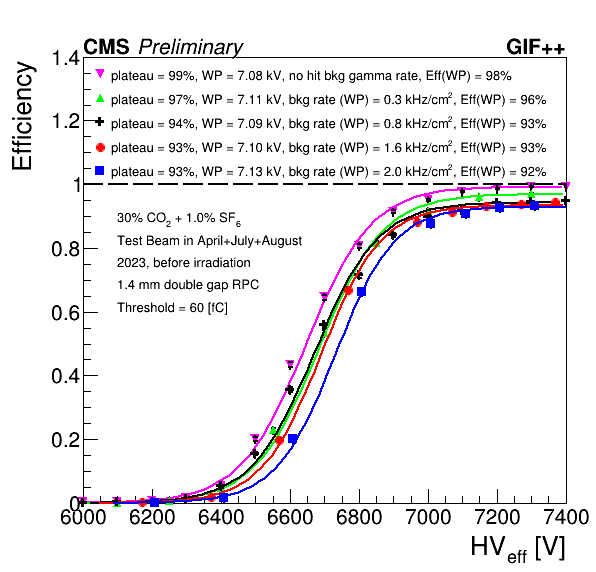

In [90]:
from ROOT import TCanvas, TGraphErrors, TLatex, TLine, TLegend
import math
import pandas as pd

# Inicializando listas para gráficos e funções
TGraphs_list_30CO2 = []
func_list_30CO2 = []

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95


k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_30CO2)
print(f"Total de scans no dicionário: {num_scans_total}")

# Listas para armazenar os dados
tabela_dados = []

for scan, sigmoid, color, marker in scans_30CO2:
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])

    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values) # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    sig.SetLineColor(color)
    gr_E.SetMarkerColor(color)
    gr_E.SetMarkerStyle(marker)

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2) # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_30CO2.append(gr_E)
    func_list_30CO2.append(sig)
    
    # Adicionando dados à tabela
    for i in range(n):
        HV_top = df['HV_top'].values[i]
        efficiency = df['efficiency'].values[i]
        eff_error = df['eff_error'].values[i]
        tabela_dados.append([scan, HV_top, efficiency, eff_error])
    
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_30CO2:
    TGraphs_list_30CO2[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_30CO2[0].SetTitle("")
    TGraphs_list_30CO2[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_30CO2[0].GetYaxis().SetTitle("Muon Efficiency")
    TGraphs_list_30CO2[0].Draw("AP")
    
    for graph in TGraphs_list_30CO2[1:]:
        graph.Draw("PSAME")

    Emax_30CO2 = []
    Emax_err_30CO2 = []
    Lambda_30CO2 = []
    Lambda_err_30CO2 = []
    HV50_30CO2 = []
    HV50_err_30CO2 = []
    HV95_30CO2 = []
    HV95_err_30CO2 = []

    for sig in func_list_30CO2:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_30CO2.append(Emax_)
        Emax_err_30CO2.append(sig.GetParError(0))     
        Lambda_30CO2.append(sig.GetParameter(1))  
        Lambda_err_30CO2.append(sig.GetParError(1))
        HV50_30CO2.append(sig.GetParameter(2))  
        HV50_err_30CO2.append(sig.GetParError(2)) 
        HV95_30CO2.append(sig.GetX(HV_ref))
        HV95_err_30CO2.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2)) # erro HV95

    WP_30CO2 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_30CO2, Lambda_30CO2, HV50_30CO2):
        WP_30CO2.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_30CO2_10 = Features_30CO2['noiseGammaRate'][2] / (Features_30CO2['gamma_CS'][2] * 1000)
    txt_30CO2_3_3 = Features_30CO2['noiseGammaRate'][5] / (Features_30CO2['gamma_CS'][5] * 1000)
    txt_30CO2_2_2 = Features_30CO2['noiseGammaRate'][6] / (Features_30CO2['gamma_CS'][6] * 1000)
    txt_30CO2_1 = Features_30CO2['noiseGammaRate'][7] / (Features_30CO2['gamma_CS'][7] * 1000)

    eff_1_30CO2_OFF = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[0], b=WP_30CO2[0] / 1000., c=(func_list_30CO2[0].Eval(WP_30CO2[0])))
    eff_2_30CO2_10 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[1], b=WP_30CO2[1] / 1000., c=(func_list_30CO2[1].Eval(WP_30CO2[1])), d=txt_30CO2_10)
    eff_3_30CO2_3_3 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[2], b=WP_30CO2[2] / 1000., c=(func_list_30CO2[2].Eval(WP_30CO2[2])), d=txt_30CO2_3_3)
    eff_4_30CO2_2_2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[3], b=WP_30CO2[3] / 1000., c=(func_list_30CO2[3].Eval(WP_30CO2[3])), d=txt_30CO2_2_2)
    eff_5_30CO2_1 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[4], b=WP_30CO2[4] / 1000., c=(func_list_30CO2[4].Eval(WP_30CO2[4])), d=txt_30CO2_1)

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary")

    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 
    legend.AddEntry(TGraphs_list_30CO2[0], eff_1_30CO2_OFF, "P")
    legend.AddEntry(TGraphs_list_30CO2[1], eff_2_30CO2_10, "P")
    legend.AddEntry(TGraphs_list_30CO2[2], eff_3_30CO2_3_3, "P")
    legend.AddEntry(TGraphs_list_30CO2[3], eff_4_30CO2_2_2, "P")
    legend.AddEntry(TGraphs_list_30CO2[4], eff_5_30CO2_1, "P")
    legend.Draw()
    canvas_all.Draw()

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(5900, 0.88, "30% CO2 + 1% SF6")
    ltx_data.DrawLatex(5900, 0.81, "Test Beam in April+July+August 2023")
    ltx_data.DrawLatex(5900, 0.74, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(5900, 0.67, "Threshold = 60 [fC]")

    line = TLine(5850, 1., 7750, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    canvas_all.cd()
    canvas_all.Draw()
else:
    print("Nenhum gráfico válido para desenhar.")

# Salvando a tabela em um arquivo CSV
tabela_df = pd.DataFrame(tabela_dados, columns=["Scan", "HV_top", "Efficiency", "Eff_Error"])
tabela_df.to_csv("tabela_dados_30CO2.csv", index=False)
print("Tabela salva em 'tabela_dados.csv'.")

In [91]:
from ROOT import TCanvas, TGraphErrors, TLatex, TLine, TLegend, TImage
import math
import pandas as pd

# Nome do arquivo CSV original
arquivo_csv = 'tabela_dados_30CO2.csv'

# Ler o arquivo CSV
df_csv = pd.read_csv(arquivo_csv)

# Ajustar os valores de HV_top para os scans especificados
df_csv.loc[df_csv['Scan'] == '30CO2_1', 'HV_top'] += 110
df_csv.loc[df_csv['Scan'] == '30CO2_2.2', 'HV_top'] += 70

# Inicializando listas para gráficos e funções
TGraphs_list_30CO2 = []
func_list_30CO2 = []

# Configurações do canvas
canvas = TCanvas("c", "c", 564, 232, 600, 600)
canvas.SetTopMargin(0.1)
canvas.SetBottomMargin(0.12)
canvas.SetLeftMargin(0.14)
canvas.SetRightMargin(0.05)

HV_ref = 95



k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_30CO2)
print(f"Total de scans no dicionário: {num_scans_total}")

for scan, sigmoid, color, marker in scans_30CO2:
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")

    # Filtrar dados do DataFrame ajustado
    df = df_csv[df_csv['Scan'] == scan]
    n = len(df['HV_top'])

    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['Efficiency'].values,
                        0,
                        df['Eff_Error'].values) # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    sig.SetLineColor(color)
    gr_E.SetMarkerColor(color)
    gr_E.SetMarkerStyle(marker)
    gr_E.SetLineWidth(2)
    gr_E.SetMarkerSize(1.2)

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2) # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_30CO2.append(gr_E)
    func_list_30CO2.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)
canvas_all.SetTopMargin(0.1)
canvas_all.SetBottomMargin(0.12)
canvas_all.SetLeftMargin(0.14)
canvas_all.SetRightMargin(0.05)

if TGraphs_list_30CO2:
    TGraphs_list_30CO2[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_30CO2[0].GetHistogram().SetMinimum(0)
    TGraphs_list_30CO2[0].SetTitle("")
    TGraphs_list_30CO2[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_30CO2[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_30CO2[0].GetXaxis().SetTitleSize(0.05)
    TGraphs_list_30CO2[0].GetYaxis().SetTitleSize(0.05)
    TGraphs_list_30CO2[0].GetXaxis().SetLabelSize(0.04)
    TGraphs_list_30CO2[0].GetYaxis().SetLabelSize(0.04)
    TGraphs_list_30CO2[0].GetXaxis().SetLimits(6000, 7400)
    TGraphs_list_30CO2[0].Draw("AP")
    
    for graph in TGraphs_list_30CO2[1:]:
        graph.Draw("PSAME")

    Emax_30CO2 = []
    Emax_err_30CO2 = []
    Lambda_30CO2 = []
    Lambda_err_30CO2 = []
    HV50_30CO2 = []
    HV50_err_30CO2 = []
    HV95_30CO2 = []
    HV95_err_30CO2 = []

    for sig in func_list_30CO2:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_30CO2.append(Emax_)
        Emax_err_30CO2.append(sig.GetParError(0))     
        Lambda_30CO2.append(sig.GetParameter(1))  
        Lambda_err_30CO2.append(sig.GetParError(1))
        HV50_30CO2.append(sig.GetParameter(2))  
        HV50_err_30CO2.append(sig.GetParError(2)) 
        HV95_30CO2.append(sig.GetX(HV_ref))
        HV95_err_30CO2.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2)) # erro HV95

    WP_30CO2 = []    

for Emax_, Lambda_, HV50_ in zip(Emax_30CO2, Lambda_30CO2, HV50_30CO2):
        WP_30CO2.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

txt_30CO2_10 = Features_30CO2['noiseGammaRate'][2] / (Features_30CO2['gamma_CS'][2] * 1000)
txt_30CO2_3_3 = Features_30CO2['noiseGammaRate'][5] / (Features_30CO2['gamma_CS'][5] * 1000)
txt_30CO2_2_2 = Features_30CO2['noiseGammaRate'][6] / (Features_30CO2['gamma_CS'][6] * 1000)
txt_30CO2_1 = Features_30CO2['noiseGammaRate'][7] / (Features_30CO2['gamma_CS'][7] * 1000)

eff_1_30CO2_OFF = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[0], b=WP_30CO2[0] / 1000., c=(func_list_30CO2[0].Eval(WP_30CO2[0])))
eff_2_30CO2_10 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[1], b=WP_30CO2[1] / 1000., c=(func_list_30CO2[1].Eval(WP_30CO2[1])), d=txt_30CO2_10)
eff_3_30CO2_3_3 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[2], b=WP_30CO2[2] / 1000., c=(func_list_30CO2[2].Eval(WP_30CO2[2])), d=txt_30CO2_3_3)
eff_4_30CO2_2_2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[3], b=WP_30CO2[3] / 1000., c=(func_list_30CO2[3].Eval(WP_30CO2[3])), d=txt_30CO2_2_2)
eff_5_30CO2_1 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[4], b=WP_30CO2[4] / 1000., c=(func_list_30CO2[4].Eval(WP_30CO2[4])), d=txt_30CO2_1)

cms_tex = TLatex()
cms_tex.SetNDC()
cms_tex.SetTextFont(61)
cms_tex.SetTextSize(0.04)
cms_tex.SetLineWidth(2)
cms_tex.DrawLatex(0.14, 0.905, "CMS")

cms_tex_1 = TLatex()
cms_tex_1.SetNDC()
cms_tex_1.SetTextFont(61)
cms_tex_1.SetTextSize(0.04)
cms_tex_1.SetLineWidth(2)
cms_tex_1.DrawLatex(0.85, 0.905, "GIF++")

cms_tex_2 = TLatex()
cms_tex_2.SetNDC()
cms_tex_2.SetTextFont(52)
cms_tex_2.SetTextSize(0.04)
cms_tex_2.SetLineWidth(2)
cms_tex_2.DrawLatex(0.23, 0.905, "Preliminary")

legend = TLegend(0.15, 0.68, 0.3, 0.89)
legend.SetTextFont(42)
legend.SetBorderSize(0) 
legend.SetFillStyle(4000)
legend.SetFillColor(0)  
legend.SetTextSize(0.02376) 
legend.AddEntry(TGraphs_list_30CO2[0], eff_1_30CO2_OFF, "P")
legend.AddEntry(TGraphs_list_30CO2[1], eff_2_30CO2_10, "P")
legend.AddEntry(TGraphs_list_30CO2[2], eff_3_30CO2_3_3, "P")
legend.AddEntry(TGraphs_list_30CO2[3], eff_4_30CO2_2_2, "P")
legend.AddEntry(TGraphs_list_30CO2[4], eff_5_30CO2_1, "P")
legend.Draw()
canvas_all.Draw()

ltx_data = TLatex()
ltx_data.SetTextFont(42)
ltx_data.SetTextSize(0.025)
ltx_data.SetTextColor(1)
ltx_data.DrawLatex(6100, 0.88, "30% CO_{2} + 1.0% SF_{6}")
ltx_data.DrawLatex(6100, 0.81, "Test Beam in April+July+August")
ltx_data.DrawLatex(6100, 0.74, "2023, before irradiation")
ltx_data.DrawLatex(6100, 0.67, "1.4 mm double gap RPC")
ltx_data.DrawLatex(6100, 0.60, "Threshold = 60 [fC]")

line = TLine(6000, 1., 7400, 1.)
line.SetLineColor(1)
line.SetLineStyle(9)
line.SetLineWidth(2)
line.Draw()


canvas_all.Update()
canvas_all.SaveAs("30CO2_eff.root")
canvas_all.SaveAs("30CO2_eff.png")
canvas_all.SaveAs("30CO2_eff.pdf")

Total de scans no dicionário: 5
Processando scan: 30CO2_OFF
Funções no gráfico após ajuste: ['sigmoid6']
Lambda = 0.010507181048171464
HV95_err = 3.070670008817123
Fit concluído para o scan: 30CO2_OFF
Processando scan: 30CO2_10
Funções no gráfico após ajuste: ['sigmoid7']
Lambda = 0.010707074819000326
HV95_err = 4.010310013336792
Fit concluído para o scan: 30CO2_10
Processando scan: 30CO2_3.3
Funções no gráfico após ajuste: ['sigmoid8']
Lambda = 0.010827850913363206
HV95_err = 3.2525853255005543
Fit concluído para o scan: 30CO2_3.3
Processando scan: 30CO2_2.2
Funções no gráfico após ajuste: ['sigmoid9']
Lambda = 0.011548113007111937
HV95_err = 4.283532907398575
Fit concluído para o scan: 30CO2_2.2
Processando scan: 30CO2_1
Funções no gráfico após ajuste: ['sigmoid10']
Lambda = 0.011663255667846619
HV95_err = 3.8839630920326873
Fit concluído para o scan: 30CO2_1
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      240.082
NDf           

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5840.000000,7760.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5935 xmax = 7915 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5935.000000,7915.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5620 xmax = 7780 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [56

In [92]:
Features_30CO205SF6 = FeaturesDataFrame(Scans_30CO205SF6)
Features_30CO205SF6['gamma_CM'][0] = 1
Features_30CO205SF6['gamma_CS'][0] = 1
Features_30CO205SF6['noiseGammaRate'][0] = 1
print("FeaturesDataFrame(Scans_30CO205SF6) = ", FeaturesDataFrame(Scans_30CO205SF6))
Features_30CO205SF6


scanID:  5833
scanID:  5839
scanID:  5836
scanID:  5837
scanID:  5835
scanID:  5834
scanID:  5838
scanID:  5840
scanID:  5833
scanID:  5839
scanID:  5836
scanID:  5837
scanID:  5835
scanID:  5834
scanID:  5838
scanID:  5840
FeaturesDataFrame(Scans_30CO205SF6) =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     0.729052     0.573356  6950.0  6950.0     0.023953      0.000650   
1     9.885142     8.778891  7060.0  7060.0     0.035293      0.017356   
2    17.803002    15.848965  7060.0  7060.0     0.028751      0.031319   
3    25.854911    22.977375  7060.0  7060.0     0.030122      0.042524   
4    33.528084    30.002467  7060.0  7060.0     0.029922      0.054032   
5    50.053757    44.876121  7060.0  7060.0     0.023695      0.072797   
6   110.092891    98.324803  7000.0  7000.0     0.015029      0.098907   
7    58.901701    52.498809  7000.0  7000.0     0.019968      0.073303   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err 

,current_top,current_bot,HV_top,HV_bot,muon_stream,gamma_stream,muon_CM,gamma_CM,muon_CS,gamma_CS,muon_CM_err,gamma_CM_err,muon_CS_err,gamma_CS_err,efficiency,eff_error,noiseGammaRate,noiseGammaRate_err,current
0,0.729052,0.573356,6950.0,6950.0,0.023953,0.000650,1.049668,1.000000,2.242913,1.000000,0.137472,0.052356,0.259732,0.057492,98.277432,0.000658,1.000000,1.844694,1.302408
1,9.885142,8.778891,7060.0,7060.0,0.035293,0.017356,1.076826,1.936739,2.647883,2.178276,0.176868,0.180727,0.373557,0.185917,98.179328,0.001361,314.975965,17.739920,18.664033
2,17.803002,15.848965,7060.0,7060.0,0.028751,0.031319,1.105946,3.066759,2.534077,2.120079,0.164453,0.273759,0.328036,0.173742,97.463618,0.001594,604.938009,24.588330,33.651967
3,25.854911,22.977375,7060.0,7060.0,0.030122,0.042524,1.128806,4.346750,2.479932,2.098029,0.155544,0.389662,0.300337,0.172604,96.877498,0.001764,890.845187,29.836912,48.832286
4,33.528084,30.002467,7060.0,7060.0,0.029922,0.054032,1.149686,5.661482,2.418002,2.055092,0.159480,0.490002,0.294557,0.163700,96.523118,0.001858,1150.351354,33.905786,63.530550
5,50.053757,44.876121,7060.0,7060.0,0.023695,0.072797,1.204097,8.739607,2.339360,1.995886,0.154333,0.728377,0.265778,0.153545,95.413920,0.002117,1732.501391,41.610476,94.929878
6,110.092891,98.324803,7000.0,7000.0,0.015029,0.098907,1.396719,21.870774,1.899861,1.723332,0.124973,1.454348,0.156031,0.107452,92.905250,0.003638,3740.656890,61.139394,208.417694
7,58.901701,52.498809,7000.0,7000.0,0.019968,0.073303,1.232308,11.017163,2.151161,1.869541,0.125834,0.811798,0.199308,0.128303,94.641179,0.003215,2047.727114,45.236057,111.400510


Total de scans no dicionário: 5
Processando scan: 30CO205SF6_OFF


Funções no gráfico após ajuste: ['sigmoid16']
Lambda = 0.009868736723696913
HV95_err = 3.2132227438513024
Fit concluído para o scan: 30CO205SF6_OFF
Processando scan: 30CO205SF6_10
Funções no gráfico após ajuste: ['sigmoid17']
Lambda = 0.01057168237103946
HV95_err = 4.548988916384935
Fit concluído para o scan: 30CO205SF6_10
Processando scan: 30CO205SF6_3.3
Funções no gráfico após ajuste: ['sigmoid18']
Lambda = 0.010911543003148966
HV95_err = 4.443635047976753
Fit concluído para o scan: 30CO205SF6_3.3
Processando scan: 30CO205SF6_2.2
Funções no gráfico após ajuste: ['sigmoid19']
Lambda = 0.011603430790325048
HV95_err = 4.20298684002922
Fit concluído para o scan: 30CO205SF6_2.2
Processando scan: 30CO205SF6_1
Funções no gráfico após ajuste: ['sigmoid20']
Lambda = 0.011322393307012558
HV95_err = 4.297504860225976
Fit concluído para o scan: 30CO205SF6_1
Tabela salva em 'tabela_dados_30CO205SF6.csv'.
****************************************
Minimizer is Minuit2 / Migrad
Chi2                  

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5815 xmax = 7435 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5815.000000,7435.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5815 xmax = 7435 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5815.000000,7435.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5815 xmax = 7435 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [58

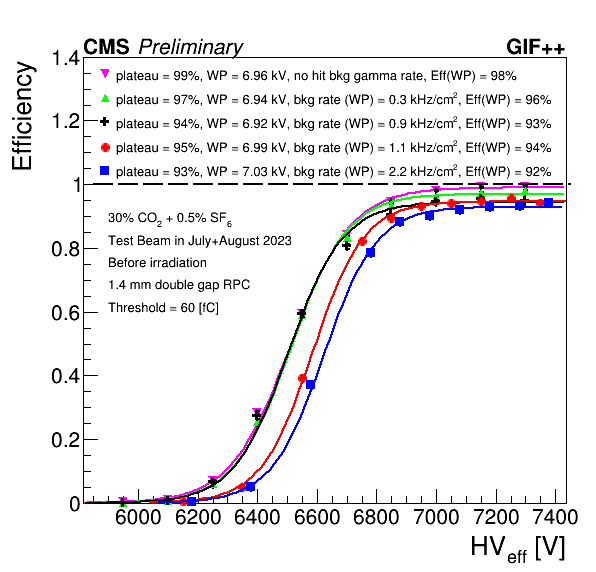

In [93]:
from ROOT import TCanvas, TGraphErrors, TLatex, TLine, TLegend
import math
import pandas as pd

# Inicializando listas para gráficos e funções
TGraphs_list_30CO205SF6 = []
func_list_30CO205SF6 = []

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95


k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_30CO205SF6)
print(f"Total de scans no dicionário: {num_scans_total}")

# Listas para armazenar os dados
tabela_dados = []

for scan, sigmoid, color, marker in scans_30CO205SF6:
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])

    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values) # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    sig.SetLineColor(color)
    gr_E.SetMarkerColor(color)
    gr_E.SetMarkerStyle(marker)

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2) # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_30CO205SF6.append(gr_E)
    func_list_30CO205SF6.append(sig)
    
    # Adicionando dados à tabela
    for i in range(n):
        HV_top = df['HV_top'].values[i]
        efficiency = df['efficiency'].values[i]
        eff_error = df['eff_error'].values[i]
        tabela_dados.append([scan, HV_top, efficiency, eff_error])
    
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_30CO205SF6:
    TGraphs_list_30CO205SF6[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_30CO205SF6[0].SetTitle("")
    TGraphs_list_30CO205SF6[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_30CO205SF6[0].GetYaxis().SetTitle("Muon Efficiency")
    TGraphs_list_30CO205SF6[0].Draw("AP")
    
    for graph in TGraphs_list_30CO205SF6[1:]:
        graph.Draw("PSAME")

    Emax_30CO205SF6 = []
    Emax_err_30CO205SF6 = []
    Lambda_30CO205SF6 = []
    Lambda_err_30CO205SF6 = []
    HV50_30CO205SF6 = []
    HV50_err_30CO205SF6 = []
    HV95_30CO205SF6 = []
    HV95_err_30CO205SF6 = []

    for sig in func_list_30CO205SF6:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_30CO205SF6.append(Emax_)
        Emax_err_30CO205SF6.append(sig.GetParError(0))     
        Lambda_30CO205SF6.append(sig.GetParameter(1))  
        Lambda_err_30CO205SF6.append(sig.GetParError(1))
        HV50_30CO205SF6.append(sig.GetParameter(2))  
        HV50_err_30CO205SF6.append(sig.GetParError(2)) 
        HV95_30CO205SF6.append(sig.GetX(HV_ref))
        HV95_err_30CO205SF6.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2)) # erro HV95

    WP_30CO205SF6 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_30CO205SF6, Lambda_30CO205SF6, HV50_30CO205SF6):
        WP_30CO205SF6.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_30CO205SF6_10 = Features_30CO205SF6['noiseGammaRate'][2] / (Features_30CO205SF6['gamma_CS'][2] * 1000)
    txt_30CO205SF6_3_3 = Features_30CO205SF6['noiseGammaRate'][5] / (Features_30CO205SF6['gamma_CS'][5] * 1000)
    txt_30CO205SF6_2_2 = Features_30CO205SF6['noiseGammaRate'][7] / (Features_30CO205SF6['gamma_CS'][7] * 1000)
    txt_30CO205SF6_1 = Features_30CO205SF6['noiseGammaRate'][6] / (Features_30CO205SF6['gamma_CS'][6] * 1000)

    eff_1_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[0], b=WP_30CO205SF6[0] / 1000., c=(func_list_30CO205SF6[0].Eval(WP_30CO205SF6[0])))
    eff_2_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[1], b=WP_30CO205SF6[1] / 1000., c=(func_list_30CO205SF6[1].Eval(WP_30CO205SF6[1])), d=txt_30CO205SF6_10)
    eff_3_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[2], b=WP_30CO205SF6[2] / 1000., c=(func_list_30CO205SF6[2].Eval(WP_30CO205SF6[2])), d=txt_30CO205SF6_3_3)
    eff_4_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[3], b=WP_30CO205SF6[3] / 1000., c=(func_list_30CO205SF6[3].Eval(WP_30CO205SF6[3])), d=txt_30CO205SF6_2_2)
    eff_5_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[4], b=WP_30CO205SF6[4] / 1000., c=(func_list_30CO205SF6[4].Eval(WP_30CO205SF6[4])), d=txt_30CO205SF6_1)

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS MUON")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary")

    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 
    legend.AddEntry(TGraphs_list_30CO205SF6[0], eff_1_30CO205SF6, "P")
    legend.AddEntry(TGraphs_list_30CO205SF6[1], eff_2_30CO205SF6, "P")
    legend.AddEntry(TGraphs_list_30CO205SF6[2], eff_3_30CO205SF6, "P")
    if len(TGraphs_list_30CO205SF6) > 3:
        legend.AddEntry(TGraphs_list_30CO205SF6[3], eff_4_30CO205SF6, "P")
    if len(TGraphs_list_30CO205SF6) > 4:
        legend.AddEntry(TGraphs_list_30CO205SF6[4], eff_5_30CO205SF6, "P")
    legend.Draw()
    canvas_all.Draw()

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(5900, 0.88, "30% CO2 + 1% SF6")
    ltx_data.DrawLatex(5900, 0.81, "Test Beam in April+July+August 2023")
    ltx_data.DrawLatex(5900, 0.74, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(5900, 0.67, "Threshold = 60 [fC]")

    line = TLine(5850, 1., 7750, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    canvas_all.cd()
    canvas_all.Draw()
else:
    print("Nenhum gráfico válido para desenhar.")

# Salvando a tabela em um arquivo CSV
tabela_df = pd.DataFrame(tabela_dados, columns=["Scan", "HV_top", "Efficiency", "Eff_Error"])
tabela_df.to_csv("tabela_dados_30CO205SF6.csv", index=False)
print("Tabela salva em 'tabela_dados_30CO205SF6.csv'.")

In [94]:
from ROOT import TCanvas, TGraphErrors, TLatex, TLine, TLegend
import math
import pandas as pd

# Nome do arquivo CSV atualizado
arquivo_csv = 'tabela_dados_30CO205SF6.csv'

# Ler o arquivo CSV
df_csv = pd.read_csv(arquivo_csv)

# Ajustar os valores de HV_top para os scans especificados
df_csv.loc[df_csv['Scan'] == '30CO205SF6_1', 'HV_top'] += 180
df_csv.loc[df_csv['Scan'] == '30CO205SF6_2.2', 'HV_top'] += 150

# Inicializando listas para gráficos e funções
TGraphs_list_30CO205SF6 = []
func_list_30CO205SF6 = []

# Configurações do canvas
canvas = TCanvas("c", "c", 564, 232, 600, 600)
canvas.SetTopMargin(0.1)
canvas.SetBottomMargin(0.12)
canvas.SetLeftMargin(0.14)
canvas.SetRightMargin(0.05)

HV_ref = 95


k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_30CO205SF6)
print(f"Total de scans no dicionário: {num_scans_total}")

for scan, sigmoid, color, marker in scans_30CO205SF6:
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")

    # Filtrar dados do DataFrame ajustado
    df = df_csv[df_csv['Scan'] == scan]
    n = len(df['HV_top'])

    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['Efficiency'].values,
                        0,
                        df['Eff_Error'].values) # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    sig.SetLineColor(color)
    gr_E.SetMarkerColor(color)
    gr_E.SetMarkerStyle(marker)
    gr_E.SetLineWidth(2)
    gr_E.SetMarkerSize(1.2)

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2) # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_30CO205SF6.append(gr_E)
    func_list_30CO205SF6.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)
canvas_all.SetTopMargin(0.1)
canvas_all.SetBottomMargin(0.12)
canvas_all.SetLeftMargin(0.14)
canvas_all.SetRightMargin(0.05)

if TGraphs_list_30CO205SF6:
    TGraphs_list_30CO205SF6[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_30CO205SF6[0].GetHistogram().SetMinimum(0)
    TGraphs_list_30CO205SF6[0].SetTitle("")
    TGraphs_list_30CO205SF6[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_30CO205SF6[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_30CO205SF6[0].GetXaxis().SetTitleSize(0.05)
    TGraphs_list_30CO205SF6[0].GetYaxis().SetTitleSize(0.05)
    TGraphs_list_30CO205SF6[0].GetXaxis().SetLabelSize(0.04)
    TGraphs_list_30CO205SF6[0].GetYaxis().SetLabelSize(0.04)
    TGraphs_list_30CO205SF6[0].Draw("AP")
    
    for graph in TGraphs_list_30CO205SF6[1:]:
        graph.Draw("PSAME")

    Emax_30CO205SF6 = []
    Emax_err_30CO205SF6 = []
    Lambda_30CO205SF6 = []
    Lambda_err_30CO205SF6 = []
    HV50_30CO205SF6 = []
    HV50_err_30CO205SF6 = []
    HV95_30CO205SF6 = []
    HV95_err_30CO205SF6 = []

    for sig in func_list_30CO205SF6:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_30CO205SF6.append(Emax_)
        Emax_err_30CO205SF6.append(sig.GetParError(0))     
        Lambda_30CO205SF6.append(sig.GetParameter(1))  
        Lambda_err_30CO205SF6.append(sig.GetParError(1))
        HV50_30CO205SF6.append(sig.GetParameter(2))  
        HV50_err_30CO205SF6.append(sig.GetParError(2)) 
        HV95_30CO205SF6.append(sig.GetX(HV_ref))
        HV95_err_30CO205SF6.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2)) # erro HV95

    WP_30CO205SF6 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_30CO205SF6, Lambda_30CO205SF6, HV50_30CO205SF6):
        WP_30CO205SF6.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_30CO205SF6_10 = Features_30CO205SF6['noiseGammaRate'][2] / (Features_30CO205SF6['gamma_CS'][2] * 1000)
    txt_30CO205SF6_3_3 = Features_30CO205SF6['noiseGammaRate'][5] / (Features_30CO205SF6['gamma_CS'][5] * 1000)
    txt_30CO205SF6_2_2 = Features_30CO205SF6['noiseGammaRate'][7] / (Features_30CO205SF6['gamma_CS'][7] * 1000)
    txt_30CO205SF6_1 = Features_30CO205SF6['noiseGammaRate'][6] / (Features_30CO205SF6['gamma_CS'][6] * 1000)

    eff_1_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[0], b=WP_30CO205SF6[0] / 1000., c=(func_list_30CO205SF6[0].Eval(WP_30CO205SF6[0])))
    eff_2_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[1], b=WP_30CO205SF6[1] / 1000., c=(func_list_30CO205SF6[1].Eval(WP_30CO205SF6[1])), d=txt_30CO205SF6_10)
    eff_3_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[2], b=WP_30CO205SF6[2] / 1000., c=(func_list_30CO205SF6[2].Eval(WP_30CO205SF6[2])), d=txt_30CO205SF6_3_3)
    eff_4_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[3], b=WP_30CO205SF6[3] / 1000., c=(func_list_30CO205SF6[3].Eval(WP_30CO205SF6[3])), d=txt_30CO205SF6_2_2)
    eff_5_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[4], b=WP_30CO205SF6[4] / 1000., c=(func_list_30CO205SF6[4].Eval(WP_30CO205SF6[4])), d=txt_30CO205SF6_1)

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.14, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.85, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.23, 0.905, "Preliminary")

    legend = TLegend(0.16, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 
    legend.AddEntry(TGraphs_list_30CO205SF6[0], eff_1_30CO205SF6, "P")
    legend.AddEntry(TGraphs_list_30CO205SF6[1], eff_2_30CO205SF6, "P")
    legend.AddEntry(TGraphs_list_30CO205SF6[2], eff_3_30CO205SF6, "P")
    legend.AddEntry(TGraphs_list_30CO205SF6[3], eff_4_30CO205SF6, "P")
    legend.AddEntry(TGraphs_list_30CO205SF6[4], eff_5_30CO205SF6, "P")
    legend.Draw()
    canvas_all.Draw()

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(5900, 0.88, "30% CO_{2} + 0.5% SF_{6}")
    ltx_data.DrawLatex(5900, 0.81, "Test Beam in July+August 2023")
    ltx_data.DrawLatex(5900, 0.74, "Before irradiation")
    ltx_data.DrawLatex(5900, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(5900, 0.60, "Threshold = 60 [fC]")

    line = TLine(5850, 1., 7450, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    canvas_all.Update()
    canvas_all.Draw()
    canvas_all.SaveAs("30CO205SF6_eff.pdf")
    canvas_all.SaveAs("30CO205SF6_eff.png")
    canvas_all.SaveAs("30CO205SF6_eff.root")
    #canvas_all.SaveAs("tabela_dados_ajustados_30CO205SF6.png")
else:
    print("Nenhum gráfico válido para desenhar.")

# Salvando a tabela em um arquivo CSV
tabela_df = pd.DataFrame(tabela_dados, columns=["Scan", "HV_top", "Efficiency", "Eff_Error"])
tabela_df.to_csv("tabela_dados_30CO205SF6.csv", index=False)
print("Tabela salva em 'tabela_dados_30CO205SF6.csv'.")

Total de scans no dicionário: 5
Processando scan: 30CO205SF6_OFF
Funções no gráfico após ajuste: ['sigmoid16']
Lambda = 0.00986873201464487
HV95_err = 3.2132173284858934
Fit concluído para o scan: 30CO205SF6_OFF
Processando scan: 30CO205SF6_10
Funções no gráfico após ajuste: ['sigmoid17']
Lambda = 0.010571606102487646
HV95_err = 4.548943535135861
Fit concluído para o scan: 30CO205SF6_10
Processando scan: 30CO205SF6_3.3
Funções no gráfico após ajuste: ['sigmoid18']
Lambda = 0.010911533061745821
HV95_err = 4.470511434629578
Fit concluído para o scan: 30CO205SF6_3.3
Processando scan: 30CO205SF6_2.2
Funções no gráfico após ajuste: ['sigmoid19']
Lambda = 0.01160329673155834
HV95_err = 4.202933515231371
Fit concluído para o scan: 30CO205SF6_2.2
Processando scan: 30CO205SF6_1
Funções no gráfico após ajuste: ['sigmoid20']
Lambda = 0.01132238523031075
HV95_err = 4.297499312826793
Fit concluído para o scan: 30CO205SF6_1
Tabela salva em 'tabela_dados_30CO205SF6.csv'.
*****************************

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5815 xmax = 7435 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5815.000000,7435.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5815 xmax = 7435 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5815.000000,7435.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5815 xmax = 7435 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [58

In [95]:
Features_40CO2 = FeaturesDataFrame(Scans_40CO2)
Features_40CO2['gamma_CM'][0] = 1
Features_40CO2['gamma_CS'][0] = 1
Features_40CO2['noiseGammaRate'][0] = 1
print("FeaturesDataFrame(Scans_40CO2) = ", FeaturesDataFrame(Scans_40CO2))
Features_40CO2

scanID:  5845
scanID:  5846
scanID:  5844


scanID:  5843
scanID:  5842
scanID:  5841
scanID:  5845
scanID:  5846
scanID:  5844
scanID:  5843
scanID:  5842
scanID:  5841
FeaturesDataFrame(Scans_40CO2) =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     0.908333     0.675833  7000.0  7000.0     0.023776      0.000225   
1     9.063140     7.805416  7000.0  7000.0     0.024847      0.011061   
2    17.024096    15.139259  7000.0  7000.0     0.025918      0.020561   
3    24.642144    21.794923  7000.0  7000.0     0.023045      0.028155   
4    32.087562    28.356041  7000.0  7000.0     0.023824      0.034470   
5    47.500257    42.183781  7000.0  7000.0     0.023215      0.048381   

    muon_CM  gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.048760  1.361280  2.379098  1.416013     0.162951      0.035061   
1  1.070776  1.867909  2.308344  1.979245     0.156086      0.150436   
2  1.095825  2.926823  2.257322  1.950481     0.149849      0.231306   
3  1.115299  4.124553  2.229258  

,current_top,current_bot,HV_top,HV_bot,muon_stream,gamma_stream,muon_CM,gamma_CM,muon_CS,gamma_CS,muon_CM_err,gamma_CM_err,muon_CS_err,gamma_CS_err,efficiency,eff_error,noiseGammaRate,noiseGammaRate_err,current
0,0.908333,0.675833,7000.0,7000.0,0.023776,0.000225,1.048760,1.000000,2.379098,1.000000,0.162951,0.035061,0.319941,0.035555,98.192179,0.001906,1.000000,2.203070,1.584167
1,9.063140,7.805416,7000.0,7000.0,0.024847,0.011061,1.070776,1.867909,2.308344,1.979245,0.156086,0.150436,0.293676,0.147522,97.480200,0.001121,272.042714,16.487786,16.868556
2,17.024096,15.139259,7000.0,7000.0,0.025918,0.020561,1.095825,2.926823,2.257322,1.950481,0.149849,0.231306,0.271545,0.142856,97.166185,0.001172,527.098160,22.950889,32.163355
3,24.642144,21.794923,7000.0,7000.0,0.023045,0.028155,1.115299,4.124553,2.229258,1.921858,0.151615,0.321327,0.266781,0.138903,96.391291,0.001885,771.747487,27.772401,46.437067
4,32.087562,28.356041,7000.0,7000.0,0.023824,0.034470,1.139349,5.370562,2.197859,1.899114,0.147606,0.411500,0.252081,0.135157,95.988859,0.001404,1007.144266,31.726279,60.443602
5,47.500257,42.183781,7000.0,7000.0,0.023215,0.048381,1.190249,8.171411,2.105764,1.839577,0.138221,0.588730,0.219095,0.123630,95.219617,0.001525,1493.011466,38.628021,89.684038


Total de scans no dicionário: 5
Processando scan: 40CO2_OFF
Funções no gráfico após ajuste: ['sigmoid11']
Lambda = 0.009825010272089214
HV95_err = 3.2182921683200805
Fit concluído para o scan: 40CO2_OFF
Processando scan: 40CO2_10
Funções no gráfico após ajuste: ['sigmoid12']
Lambda = 0.010292391209836858
HV95_err = 3.27227030755666
Fit concluído para o scan: 40CO2_10
Processando scan: 40CO2_6.9
Funções no gráfico após ajuste: ['sigmoid14']
Lambda = 0.010184036636144216
HV95_err = 3.39404400839822
Fit concluído para o scan: 40CO2_6.9
Processando scan: 40CO2_4.6
Funções no gráfico após ajuste: ['sigmoid20']
Lambda = 0.010473460474165534
HV95_err = 3.3110780674446803
Fit concluído para o scan: 40CO2_4.6
Processando scan: 40CO2_3.3
Funções no gráfico após ajuste: ['sigmoid13']
Lambda = 0.010931459023892703
HV95_err = 3.194750194295551
Fit concluído para o scan: 40CO2_3.3
Tabela salva em 'tabela_dados_40CO2.csv'.
****************************************
Minimizer is Minuit2 / Migrad
Chi2   

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5840.000000,7760.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5640.000000,7560.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [56

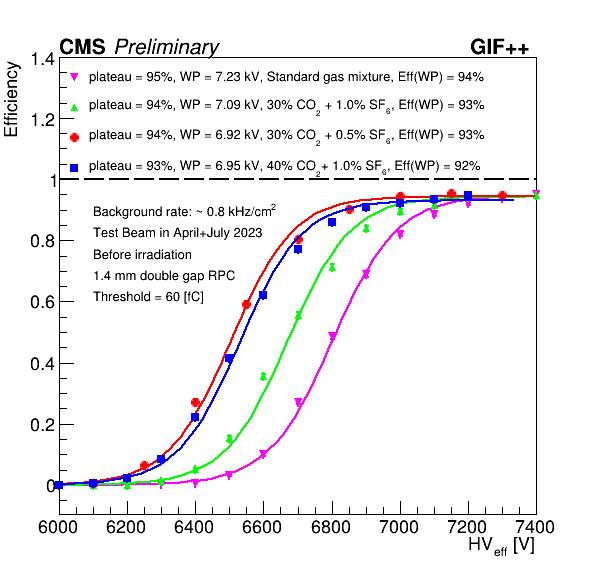

In [96]:
from ROOT import TCanvas, TGraphErrors, TLatex, TLine, TLegend
import math
import pandas as pd

# Inicializando listas para gráficos e funções
TGraphs_list_40CO2 = []
func_list_40CO2 = []

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_40CO2)
print(f"Total de scans no dicionário: {num_scans_total}")

# Listas para armazenar os dados
tabela_dados = []

for scan, sigmoid, color, marker in scans_40CO2:
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])

    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values) # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    sig.SetLineColor(color)
    gr_E.SetMarkerColor(color)
    gr_E.SetMarkerStyle(marker)

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2) # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_40CO2.append(gr_E)
    func_list_40CO2.append(sig)
    
    # Adicionando dados à tabela
    for i in range(n):
        HV_top = df['HV_top'].values[i]
        efficiency = df['efficiency'].values[i]
        eff_error = df['eff_error'].values[i]
        tabela_dados.append([scan, HV_top, efficiency, eff_error])
    
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_40CO2:
    TGraphs_list_40CO2[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_40CO2[0].SetTitle("")
    TGraphs_list_40CO2[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_40CO2[0].GetYaxis().SetTitle("Muon Efficiency")
    TGraphs_list_40CO2[0].Draw("AP")
    
    for graph in TGraphs_list_40CO2[1:]:
        graph.Draw("PSAME")

    Emax_40CO2 = []
    Emax_err_40CO2 = []
    Lambda_40CO2 = []
    Lambda_err_40CO2 = []
    HV50_40CO2 = []
    HV50_err_40CO2 = []
    HV95_40CO2 = []
    HV95_err_40CO2 = []

    for sig in func_list_40CO2:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_40CO2.append(Emax_)
        Emax_err_40CO2.append(sig.GetParError(0))     
        Lambda_40CO2.append(sig.GetParameter(1))  
        Lambda_err_40CO2.append(sig.GetParError(1))
        HV50_40CO2.append(sig.GetParameter(2))  
        HV50_err_40CO2.append(sig.GetParError(2)) 
        HV95_40CO2.append(sig.GetX(HV_ref))
        HV95_err_40CO2.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2)) # erro HV95

    WP_40CO2 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_40CO2, Lambda_40CO2, HV50_40CO2):
        WP_40CO2.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    # Atualizando os textos para o novo conjunto de dados
    txt_40CO2_10 = Features_40CO2['noiseGammaRate'][2] / (Features_40CO2['gamma_CS'][2] * 1000)
    txt_40CO2_3_3 = Features_40CO2['noiseGammaRate'][3] / (Features_40CO2['gamma_CS'][3] * 1000)
    txt_40CO2_2_2 = Features_40CO2['noiseGammaRate'][4] / (Features_40CO2['gamma_CS'][4] * 1000)
    txt_40CO2_1 = Features_40CO2['noiseGammaRate'][5] / (Features_40CO2['gamma_CS'][5] * 1000)

    eff_1_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[0], b=WP_40CO2[0] / 1000., c=(func_list_40CO2[0].Eval(WP_40CO2[0])))
    eff_2_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[1], b=WP_40CO2[1] / 1000., c=(func_list_40CO2[1].Eval(WP_40CO2[1])), d=txt_40CO2_10)
    eff_3_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[2], b=WP_40CO2[2] / 1000., c=(func_list_40CO2[2].Eval(WP_40CO2[2])), d=txt_40CO2_3_3)
    eff_4_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[3], b=WP_40CO2[3] / 1000., c=(func_list_40CO2[3].Eval(WP_40CO2[3])), d=txt_40CO2_2_2)
    eff_5_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[4], b=WP_40CO2[4] / 1000., c=(func_list_40CO2[4].Eval(WP_40CO2[4])), d=txt_40CO2_1)

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS MUON")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary")

    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 
    legend.AddEntry(TGraphs_list_40CO2[0], eff_1_40CO2, "P")
    legend.AddEntry(TGraphs_list_40CO2[1], eff_2_40CO2, "P")
    legend.AddEntry(TGraphs_list_40CO2[2], eff_3_40CO2, "P")
    if len(TGraphs_list_40CO2) > 3:
        legend.AddEntry(TGraphs_list_40CO2[3], eff_4_40CO2, "P")
    if len(TGraphs_list_40CO2) > 4:
        legend.AddEntry(TGraphs_list_40CO2[4], eff_5_40CO2, "P")
    legend.Draw()
    canvas_all.Draw()

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(5900, 0.88, "40% CO2 + 2% SF6")
    ltx_data.DrawLatex(5900, 0.81, "Test Beam in April+July+August 2024")
    ltx_data.DrawLatex(5900, 0.74, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(5900, 0.67, "Threshold = 60 [fC]")

    line = TLine(5850, 1., 7750, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    canvas_all.cd()
    canvas_all.Draw()
else:
    print("Nenhum gráfico válido para desenhar.")

# Salvando a tabela em um arquivo CSV
tabela_df = pd.DataFrame(tabela_dados, columns=["Scan", "HV_top", "Efficiency", "Eff_Error"])
tabela_df.to_csv("tabela_dados_40CO2.csv", index=False)
print("Tabela salva em 'tabela_dados_40CO2.csv'.")

In [97]:
from ROOT import TCanvas, TGraphErrors, TLatex, TLine, TLegend
import math
import pandas as pd

# Nome do arquivo CSV atualizado
arquivo_csv = 'tabela_dados_40CO2.csv'

# Ler o arquivo CSV
df_csv = pd.read_csv(arquivo_csv)

# Ajustar os valores de HV_top para os scans especificados
df_csv.loc[df_csv['Scan'] == '40CO2_3.3', 'HV_top'] += 80
df_csv.loc[df_csv['Scan'] == '40CO2_4.6', 'HV_top'] += 40

# Inicializando listas para gráficos e funções
TGraphs_list_40CO2 = []
func_list_40CO2 = []

# Configurações do canvas
canvas = TCanvas("c", "c", 564, 232, 600, 600)
canvas.SetTopMargin(0.1)
canvas.SetBottomMargin(0.12)
canvas.SetLeftMargin(0.14)
canvas.SetRightMargin(0.05)

HV_ref = 95


k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_40CO2)
print(f"Total de scans no dicionário: {num_scans_total}")

for scan, sigmoid, color, marker in scans_40CO2:
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")

    # Filtrar dados do DataFrame ajustado
    df = df_csv[df_csv['Scan'] == scan]
    n = len(df['HV_top'])

    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['Efficiency'].values,
                        0,
                        df['Eff_Error'].values) # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    sig.SetLineColor(color)
    gr_E.SetMarkerColor(color)
    gr_E.SetMarkerStyle(marker)
    gr_E.SetLineWidth(2)
    gr_E.SetMarkerSize(1.2)

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2) # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_40CO2.append(gr_E)
    func_list_40CO2.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)
canvas_all.SetTopMargin(0.1)
canvas_all.SetBottomMargin(0.12)
canvas_all.SetLeftMargin(0.14)
canvas_all.SetRightMargin(0.05)

if TGraphs_list_40CO2:
    TGraphs_list_40CO2[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_40CO2[0].GetHistogram().SetMinimum(0)
    TGraphs_list_40CO2[0].SetTitle("")
    TGraphs_list_40CO2[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_40CO2[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_40CO2[0].GetXaxis().SetTitleSize(0.05)
    TGraphs_list_40CO2[0].GetYaxis().SetTitleSize(0.05)
    TGraphs_list_40CO2[0].GetXaxis().SetLabelSize(0.04)
    TGraphs_list_40CO2[0].GetYaxis().SetLabelSize(0.04)
    TGraphs_list_40CO2[0].GetXaxis().SetLimits(6000, 7400)
    TGraphs_list_40CO2[0].Draw("AP")
    
    for graph in TGraphs_list_40CO2[1:]:
        graph.Draw("PSAME")

    Emax_40CO2 = []
    Emax_err_40CO2 = []
    Lambda_40CO2 = []
    Lambda_err_40CO2 = []
    HV50_40CO2 = []
    HV50_err_40CO2 = []
    HV95_40CO2 = []
    HV95_err_40CO2 = []

    for sig in func_list_40CO2:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_40CO2.append(Emax_)
        Emax_err_40CO2.append(sig.GetParError(0))     
        Lambda_40CO2.append(sig.GetParameter(1))  
        Lambda_err_40CO2.append(sig.GetParError(1))
        HV50_40CO2.append(sig.GetParameter(2))  
        HV50_err_40CO2.append(sig.GetParError(2)) 
        HV95_40CO2.append(sig.GetX(HV_ref))
        HV95_err_40CO2.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2)) # erro HV95

    WP_40CO2 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_40CO2, Lambda_40CO2, HV50_40CO2):
        WP_40CO2.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_40CO2_10 = Features_40CO2['noiseGammaRate'][2] / (Features_40CO2['gamma_CS'][2] * 1000)
    txt_40CO2_3_3 = Features_40CO2['noiseGammaRate'][3] / (Features_40CO2['gamma_CS'][3] * 1000)
    txt_40CO2_2_2 = Features_40CO2['noiseGammaRate'][4] / (Features_40CO2['gamma_CS'][4] * 1000)
    txt_40CO2_1 = Features_40CO2['noiseGammaRate'][5] / (Features_40CO2['gamma_CS'][5] * 1000)

    eff_1_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[0], b=WP_40CO2[0] / 1000., c=(func_list_40CO2[0].Eval(WP_40CO2[0])))
    eff_2_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[1], b=WP_40CO2[1] / 1000., c=(func_list_40CO2[1].Eval(WP_40CO2[1])), d=txt_40CO2_10)
    eff_3_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[2], b=WP_40CO2[2] / 1000., c=(func_list_40CO2[2].Eval(WP_40CO2[2])), d=txt_40CO2_3_3)
    eff_4_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[3], b=WP_40CO2[3] / 1000., c=(func_list_40CO2[3].Eval(WP_40CO2[3])), d=txt_40CO2_2_2)
    eff_5_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[4], b=WP_40CO2[4] / 1000., c=(func_list_40CO2[4].Eval(WP_40CO2[4])), d=txt_40CO2_1)

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.14, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.85, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.23, 0.905, "Preliminary")

    legend = TLegend(0.15, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 
    legend.AddEntry(TGraphs_list_40CO2[0], eff_1_40CO2, "P")
    legend.AddEntry(TGraphs_list_40CO2[1], eff_2_40CO2, "P")
    legend.AddEntry(TGraphs_list_40CO2[2], eff_3_40CO2, "P")
    legend.AddEntry(TGraphs_list_40CO2[3], eff_4_40CO2, "P")
    legend.AddEntry(TGraphs_list_40CO2[4], eff_5_40CO2, "P")
    legend.Draw()
    canvas_all.Draw()

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6050, 0.88, "40% CO_{2} + 1.0% SF_{6}")
    ltx_data.DrawLatex(6050, 0.81, "Test Beam in April+July+August")
    ltx_data.DrawLatex(6050, 0.74, "2023, Before irradiation")
    ltx_data.DrawLatex(6050, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6050, 0.60, "Threshold = 60 [fC]")

    line = TLine(6000, 1., 7400, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    canvas_all.Update()
    canvas_all.SaveAs("40CO2_eff.pdf")
    canvas_all.SaveAs("40CO2_eff.png")
    canvas_all.SaveAs("40CO2_eff.root")
else:
    print("Nenhum gráfico válido para desenhar.")

# Salvando a tabela em um arquivo CSV
tabela_df = pd.DataFrame(tabela_dados, columns=["Scan", "HV_top", "Efficiency", "Eff_Error"])
tabela_df.to_csv("tabela_dados_40CO2.csv", index=False)
print("Tabela salva em 'tabela_dados_40CO2.csv'.")

Total de scans no dicionário: 5
Processando scan: 40CO2_OFF
Funções no gráfico após ajuste: ['sigmoid11']
Lambda = 0.009824715646634752
HV95_err = 3.2181281241580177
Fit concluído para o scan: 40CO2_OFF
Processando scan: 40CO2_10
Funções no gráfico após ajuste: ['sigmoid12']
Lambda = 0.010292375064091107
HV95_err = 3.2722653858912336
Fit concluído para o scan: 40CO2_10
Processando scan: 40CO2_6.9
Funções no gráfico após ajuste: ['sigmoid14']
Lambda = 0.010183969099000352
HV95_err = 3.393993214796128
Fit concluído para o scan: 40CO2_6.9
Processando scan: 40CO2_4.6
Funções no gráfico após ajuste: ['sigmoid20']
Lambda = 0.01047351150128923
HV95_err = 3.3110802709612077
Fit concluído para o scan: 40CO2_4.6
Processando scan: 40CO2_3.3
Funções no gráfico após ajuste: ['sigmoid13']
Lambda = 0.010931554867856783
HV95_err = 3.22197088461028
Fit concluído para o scan: 40CO2_3.3
Tabela salva em 'tabela_dados_40CO2.csv'.
****************************************
Minimizer is Minuit2 / Migrad
Chi2  

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5840.000000,7760.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5640.000000,7560.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [56

In [98]:
Features_OFF = FeaturesDataFrame(Scans_OFF)
print("Features_OFF = ", Features_OFF)

scanID:  5833
scanID:  5808
scanID:  5845
scanID:  5819
Features_OFF =  

   current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     0.729052     0.573356  6950.0  6950.0     0.023953      0.000650   
1     0.662577     0.579678  7250.0  7250.0     0.021638      0.000510   
2     0.908333     0.675833  7000.0  7000.0     0.023776      0.000225   
3     0.516166     0.416491  7060.0  7060.0     0.018003      0.000250   

    muon_CM  gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.049668  1.337696  2.242913  1.526419     0.137472      0.052356   
1  1.056347  1.686717  2.149189  1.335598     0.128334      0.049051   
2  1.048760  1.361280  2.379098  1.416013     0.162951      0.035061   
3  1.046605  1.380734  2.027942  1.553710     0.114498      0.041284   

   muon_CS_err  gamma_CS_err  efficiency  eff_error  noiseGammaRate  \
0     0.259732      0.057492   98.277432   0.000658        3.886514   
1     0.232817      0.037743   98.604936   0.000838        6.272502   
2     0.319941      0.035555   98.192179   0.001906    

In [99]:
from ROOT import TCanvas, TGraphErrors, TLatex, TLine, TLegend
import math

# Inicializando listas para gráficos e funções
TGraphs_list_OFF = []
func_list_OFF = []

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

# Definições de cores e marcadores
colors = [6, 3, 2, 4]  # ROOT Colors: 2 (Red), 4 (Blue), 3 (Green), 6 (Magenta), 8 (Cyan)
markers = [23, 22, 20, 21]  # Marcadores: 20 (circulo), 21 (quadrado), 22 (triângulo), etc.

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_OFF)
print(f"Total de scans no dicionário: {num_scans_total}")

for index, (scan, sigmoid, color, marker) in enumerate(scans_OFF):
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values) # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Usando cores e marcadores diferentes para cada gráfico
    color = colors[index % len(colors)]
    marker = markers[index % len(markers)]
    
    sig.SetLineColor(color)
    gr_E.SetMarkerColor(color)
    gr_E.SetMarkerStyle(marker)

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2) # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_OFF.append(gr_E)
    func_list_OFF.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_OFF:
    TGraphs_list_OFF[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_OFF[0].SetTitle("")
    TGraphs_list_OFF[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_OFF[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_OFF[0].GetXaxis().SetLimits(6000, 7400)
    TGraphs_list_OFF[0].Draw("AP")
    
    for graph in TGraphs_list_OFF[1:]:
        graph.Draw("PSAME")

    Emax_OFF = []
    Emax_err_OFF = []
    Lambda_OFF = []
    Lambda_err_OFF = []
    HV50_OFF = []
    HV50_err_OFF = []
    HV95_OFF = []
    HV95_err_OFF = []

    for sig in func_list_OFF:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_OFF.append(Emax_)
        Emax_err_OFF.append(sig.GetParError(0))     
        Lambda_OFF.append(sig.GetParameter(1))  
        Lambda_err_OFF.append(sig.GetParError(1))
        HV50_OFF.append(sig.GetParameter(2))  
        HV50_err_OFF.append(sig.GetParError(2)) 
        HV95_OFF.append(sig.GetX(HV_ref))
        HV95_err_OFF.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2)) # erro HV95

    WP_OFF = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_OFF, Lambda_OFF, HV50_OFF):
        WP_OFF.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    #txt_OFF_22 = Features_OFF['noiseGammaRate'][2] / (Features_OFF['gamma_CS'][2] * 1000)
    #txt_OFF_10 = Features_OFF['noiseGammaRate'][4] / (Features_OFF['gamma_CS'][4] * 1000)
    #txt_OFF_46 = Features_OFF['noiseGammaRate'][5] / (Features_OFF['gamma_CS'][5] * 1000)
    #txt_OFF_33 = Features_OFF['noiseGammaRate'][7] / (Features_OFF['gamma_CS'][7] * 1000)

    # Adiciona verificações de comprimento antes de formatar strings
    eff_1_OFF = 'plateau = {a:.0%}, WP = {b:.2f} kV, Standard gas mixture, Eff(WP) = {c:.0%}'.format(a=Emax_OFF[0], b=WP_OFF[0] / 1000., c=(func_list_OFF[0].Eval(WP_OFF[0])))
    eff_2_OFF = 'plateau = {a:.0%}, WP = {b:.2f} kV, 30% CO_{{2}} + 1.0% SF_{{6}}, Eff(WP) = {c:.0%}'.format(a=Emax_OFF[1], b=WP_OFF[1] / 1000., c=(func_list_OFF[1].Eval(WP_OFF[1])))
    eff_3_OFF = 'plateau = {a:.0%}, WP = {b:.2f} kV, 30% CO_{{2}} + 0.5% SF_{{6}}, Eff(WP) = {c:.0%}'.format(a=Emax_OFF[2], b=WP_OFF[2] / 1000., c=(func_list_OFF[2].Eval(WP_OFF[2])))
    eff_4_OFF = 'plateau = {a:.0%}, WP = {b:.2f} kV, 40% CO_{{2}}+ 1.0% SF_{{6}}, Eff(WP) = {c:.0%}'.format(a=Emax_OFF[3], b=WP_OFF[3] / 1000., c=(func_list_OFF[3].Eval(WP_OFF[3])))

    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6100, 0.88, "No gamma background")
    ltx_data.DrawLatex(6100, 0.81, "Test Beam in April+July 2023")
    ltx_data.DrawLatex(6100, 0.74, "Before irradiation")
    ltx_data.DrawLatex(6100, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6100, 0.60, "Threshold = 60 [fC]")

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.19, 0.905, "Preliminary")

    line = TLine(6000, 1., 7400, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_OFF[0], eff_1_OFF, "P")
    legend.AddEntry(TGraphs_list_OFF[1], eff_2_OFF, "P")
    legend.AddEntry(TGraphs_list_OFF[2], eff_3_OFF, "P")
    legend.AddEntry(TGraphs_list_OFF[3], eff_4_OFF, "P")
    #legend.AddEntry(TGraphs_list_OFF[4], eff_5_OFF, "P")

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("OFF_eff.png")
canvas_all.SaveAs("OFF_eff.pdf")
canvas_all.SaveAs("OFF_eff.root")

Total de scans no dicionário: 4
Processando scan: STDMX_OFF
Funções no gráfico após ajuste: ['sigmoid1']
Lambda = 0.012161892782944023
HV95_err = 3.7542268201599223
Fit concluído para o scan: STDMX_OFF
Processando scan: 30CO2_OFF
Funções no gráfico após ajuste: ['sigmoid6']
Lambda = 0.01050718089512795
HV95_err = 3.0706699135950037
Fit concluído para o scan: 30CO2_OFF
Processando scan: 30CO205SF6_OFF
Funções no gráfico após ajuste: ['sigmoid16']
Lambda = 0.009868738633502284
HV95_err = 3.2132193837874103
Fit concluído para o scan: 30CO205SF6_OFF
Processando scan: 40CO2_OFF
Funções no gráfico após ajuste: ['sigmoid11']
Lambda = 0.009824684138865362
HV95_err = 3.2181265717418532
Fit concluído para o scan: 40CO2_OFF
Gráficos e legendas adicionados ao canvas.
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      14.1711
NDf                       =            7
Edm                       =   1.3994e-07
NCalls                    =           37

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6070 xmax = 7630 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [6070.000000,7630.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5840.000000,7760.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5815 xmax = 7435 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [58

In [100]:
'''''
Features_22 = FeaturesDataFrame(Scans_22)
print("Features_OFF = ", Features_22)
'''''

'\'\'\nFeatures_22 = FeaturesDataFrame(Scans_22)\nprint("Features_OFF = ", Features_22)\n'

In [101]:
''''
from ROOT import TCanvas, TGraphErrors, TLatex, TLine, TLegend
import math

# Inicializando listas para gráficos e funções
TGraphs_list_22 = []
func_list_22 = []

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

# Definições de cores e marcadores
colors = [2, 4, 3, 6, 8]  # ROOT Colors: 2 (Red), 4 (Blue), 3 (Green), 6 (Magenta), 8 (Cyan)
markers = [22]  # Marcador: 22 (triângulo)

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_22)
print(f"Total de scans no dicionário: {num_scans_total}")

for index, (scan, sigmoid, _, _) in enumerate(scans_22):
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values)  # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Usando cores diferentes e o marcador 22 para cada gráfico
    color = colors[index % len(colors)]
    gr_E.SetMarkerColor(color)
    gr_E.SetMarkerStyle(markers[0])
    sig.SetLineColor(color)

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2) # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_22.append(gr_E)
    func_list_22.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_22:
    TGraphs_list_22[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_22[0].SetTitle("")
    TGraphs_list_22[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_22[0].GetYaxis().SetTitle("Muon Efficiency")
    TGraphs_list_22[0].Draw("AP")
    
    for graph in TGraphs_list_22[1:]:
        graph.Draw("PSAME")

    Emax_22 = []
    Emax_err_22 = []
    Lambda_22 = []
    Lambda_err_22 = []
    HV50_22 = []
    HV50_err_22 = []
    HV95_22 = []
    HV95_err_22 = []

    for sig in func_list_22:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_22.append(Emax_)
        Emax_err_22.append(sig.GetParError(0))     
        Lambda_22.append(sig.GetParameter(1))  
        Lambda_err_22.append(sig.GetParError(1))
        HV50_22.append(sig.GetParameter(2))  
        HV50_err_22.append(sig.GetParError(2)) 
        HV95_22.append(sig.GetX(HV_ref))
        HV95_err_22.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2)) # erro HV95

    WP_22 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_22, Lambda_22, HV50_22):
        WP_22.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_22_22 = Features_22['noiseGammaRate'][0] / (Features_22['gamma_CS'][0] * 1000)
    txt_22_10 = Features_22['noiseGammaRate'][1] / (Features_22['gamma_CS'][1] * 1000)
    txt_22_46 = Features_22['noiseGammaRate'][2] / (Features_22['gamma_CS'][2] * 1000)
    txt_22_33 = Features_22['noiseGammaRate'][3] / (Features_22['gamma_CS'][3] * 1000)
    print(txt_22_22, txt_22_10, txt_22_46, txt_22_33)

    # Adiciona verificações de comprimento antes de formatar strings
    if len(Emax_22) > 0:
        eff_1_22 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(
            a=Emax_22[0], 
            b=WP_22[0] / 1000., 
            c=(func_list_22[0].Eval(WP_22[0])),
            d=txt_22_22
        )
    else:
        eff_1_22 = 'Dados insuficientes para o primeiro gráfico.'

    if len(Emax_22) > 1:
        eff_2_22 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(
            a=Emax_22[1], 
            b=WP_22[1] / 1000., 
            c=(func_list_22[1].Eval(WP_22[1])), 
            d=txt_22_10
        )
    else:
        eff_2_22 = 'Dados insuficientes para o segundo gráfico.'

    if len(Emax_22) > 2:
        eff_3_22 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(
            a=Emax_22[2], 
            b=WP_22[2] / 1000., 
            c=(func_list_22[2].Eval(WP_22[2])), 
            d=txt_22_46
        )
    else:
        eff_3_22 = 'Dados insuficientes para o terceiro gráfico.'

    if len(Emax_22) > 3:
        eff_4_22 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(
            a=Emax_22[3], 
            b=WP_22[3] / 1000., 
            c=(func_list_22[3].Eval(WP_22[3])), 
            d=txt_22_33
        )

    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(5900, 0.88, "95.2% TFE + 4.5% iC4H10 + 0.3% SF6")
    ltx_data.DrawLatex(5900, 0.81, "Test Beam in April+July 2023")
    ltx_data.DrawLatex(5900, 0.74, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(5900, 0.67, "Threshold = 60 [fC]")

    line = TLine(5850, 1., 7450, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    if len(TGraphs_list_22) > 0:
        legend.AddEntry(TGraphs_list_22[0], eff_1_22, "P")
    if len(TGraphs_list_22) > 1:
        legend.AddEntry(TGraphs_list_22[1], eff_2_22, "P")
    if len(TGraphs_list_22) > 2:
        legend.AddEntry(TGraphs_list_22[2], eff_3_22, "P")
    if len(TGraphs_list_22) > 3:
        legend.AddEntry(TGraphs_list_22[3], eff_4_22, "P")
    if len(TGraphs_list_22) > 4:
        legend.AddEntry(TGraphs_list_22[4], eff_5_22, "P")

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("22_final.png")
canvas_all.SaveAs("22_final.pdf")
'''

'\'\nfrom ROOT import TCanvas, TGraphErrors, TLatex, TLine, TLegend\nimport math\n\n# Inicializando listas para gráficos e funções\nTGraphs_list_22 = []\nfunc_list_22 = []\n\ncanvas = TCanvas("c", "c", 564, 232, 600, 600)\nHV_ref = 95\n\n# Definições de cores e marcadores\ncolors = [2, 4, 3, 6, 8]  # ROOT Colors: 2 (Red), 4 (Blue), 3 (Green), 6 (Magenta), 8 (Cyan)\nmarkers = [22]  # Marcador: 22 (triângulo)\n\nk = 1\n\n# Contagem dos scans no dicionário\nnum_scans_total = len(scans_22)\nprint(f"Total de scans no dicionário: {num_scans_total}")\n\nfor index, (scan, sigmoid, _, _) in enumerate(scans_22):\n    if scan not in scans:\n        print(f"Scan \'{scan}\' não encontrado no dicionário de scans. Pulando...")\n        continue\n    \n    print(f"Processando scan: {scan}")\n    \n    df = HVCurrentDataFrame(scans[scan])\n    n = len(df[\'HV_top\'])\n    \n    gr_E = TGraphErrors(n, \n                        df[\'HV_top\'].values, \n                        df[\'efficiency\'].values,\n

In [102]:
Features_33 = FeaturesDataFrame(Scans_33)
print("Features_OFF = ", Features_33)

scanID:  5814
scanID:  5822
scanID:  5834
scanID:  5841
Features_OFF =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0    38.579806    33.307197  7250.0  7250.0     0.016467      0.040073   
1    42.202164    36.301476  7060.0  7060.0     0.016382      0.034044   
2    50.053757    44.876121  7060.0  7060.0     0.023695      0.072797   
3    47.500257    42.183781  7000.0  7000.0     0.023215      0.048381   

    muon_CM  gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.190779  8.088920  1.989675  1.750194     0.114043      0.550905   
1  1.170880  7.823211  1.878253  1.715422     0.100166      0.493850   
2  1.204097  8.739607  2.339360  1.995886     0.154333      0.728377   
3  1.190249  8.171411  2.105764  1.839577     0.138221      0.588730   

   muon_CS_err  gamma_CS_err  efficiency  eff_error  noiseGammaRate  \
0     0.173901      0.111598   95.672184   0.002050     1405.879286   
1     0.148017      0.101858   94.920933   0.001565   

In [103]:
from ROOT import TCanvas, TGraphErrors, TLatex, TLine, TLegend
import math

# Inicializando listas para gráficos e funções
TGraphs_list_33 = []
func_list_33 = []

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

colors = [6, 3, 2, 4]  # ROOT Colors: 2 (Red), 4 (Blue), 3 (Green), 6 (Magenta), 8 (Cyan)
markers = [23, 22, 20, 21]  # Marcadores: 20 (circulo), 21 (quadrado), 22 (triângulo), etc.

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_33)
print(f"Total de scans no dicionário: {num_scans_total}")

for index, (scan, sigmoid, _, _) in enumerate(scans_33):
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values)  # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Usando cores e marcadores diferentes para cada gráfico
    color = colors[index % len(colors)]
    marker = markers[index % len(markers)]
    gr_E.SetMarkerColor(color)
    gr_E.SetMarkerStyle(marker)
    sig.SetLineColor(color)

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2) # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_33.append(gr_E)
    func_list_33.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_33:
    TGraphs_list_33[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_33[0].SetTitle("")
    TGraphs_list_33[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_33[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_33[0].GetXaxis().SetLimits(6000, 7400)
    TGraphs_list_33[0].Draw("AP")
    
    for graph in TGraphs_list_33[1:]:
        graph.Draw("PSAME")

    Emax_33 = []
    Emax_err_33 = []
    Lambda_33 = []
    Lambda_err_33 = []
    HV50_33 = []
    HV50_err_33 = []
    HV95_33 = []
    HV95_err_33 = []

    for sig in func_list_33:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_33.append(Emax_)
        Emax_err_33.append(sig.GetParError(0))     
        Lambda_33.append(sig.GetParameter(1))  
        Lambda_err_33.append(sig.GetParError(1))
        HV50_33.append(sig.GetParameter(2))  
        HV50_err_33.append(sig.GetParError(2)) 
        HV95_33.append(sig.GetX(HV_ref))
        HV95_err_33.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2)) # erro HV95

    WP_33 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_33, Lambda_33, HV50_33):
        WP_33.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_33_33 = Features_33['noiseGammaRate'][0] / (Features_33['gamma_CS'][0] * 1000)
    txt_33_10 = Features_33['noiseGammaRate'][1] / (Features_33['gamma_CS'][1] * 1000)
    txt_33_46 = Features_33['noiseGammaRate'][2] / (Features_33['gamma_CS'][2] * 1000)
    txt_33_33 = Features_33['noiseGammaRate'][3] / (Features_33['gamma_CS'][3] * 1000)
    print(txt_33_33, txt_33_10, txt_33_46, txt_33_33)

    # Adiciona verificações de comprimento antes de formatar strings
    if len(Emax_33) > 0:
        eff_1_33 = 'plateau = {a:.0%}, WP = {b:.2f} kV, Standard gas mixture, Eff(WP) = {c:.0%}'.format(
            a=Emax_33[0], 
            b=WP_33[0] / 1000., 
            c=(func_list_33[0].Eval(WP_33[0])),
            d=txt_33_33
        )
    else:
        eff_1_33 = 'Dados insuficientes para o primeiro gráfico.'

    if len(Emax_33) > 1:
        eff_2_33 = 'plateau = {a:.0%}, WP = {b:.2f} kV, 30% CO_{{2}} + 1.0% SF_{{6}}, Eff(WP) = {c:.0%}'.format(
            a=Emax_33[1], 
            b=WP_33[1] / 1000., 
            c=(func_list_33[1].Eval(WP_33[1])), 
            d=txt_33_10
        )
    else:
        eff_2_33 = 'Dados insuficientes para o segundo gráfico.'

    if len(Emax_33) > 2:
        eff_3_33 = 'plateau = {a:.0%}, WP = {b:.2f} kV, 30% CO_{{2}} + 0.5% SF_{{6}}, Eff(WP) = {c:.0%}'.format(
            a=Emax_33[2], 
            b=WP_33[2] / 1000., 
            c=(func_list_33[2].Eval(WP_33[2])), 
            d=txt_33_46
        )
    else:
        eff_3_33 = 'Dados insuficientes para o terceiro gráfico.'

    if len(Emax_33) > 3:
        eff_4_33 = 'plateau = {a:.0%}, WP = {b:.2f} kV, 40% CO_{{2}} + 1.0% SF_{{6}}, Eff(WP) = {c:.0%}'.format(
            a=Emax_33[3], 
            b=WP_33[3] / 1000., 
            c=(func_list_33[3].Eval(WP_33[3])), 
            d=txt_33_33
        )

    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    ltx_data = TLatex()
    ltx_data.SetTextFont(41)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6050, 0.88, "Background rate ~ 0.8kHz/cm^{2}") 
    ltx_data.DrawLatex(6050, 0.81, "Test Beam in April+July+August")
    ltx_data.DrawLatex(6050, 0.74, "2023, Before irradiation")
    ltx_data.DrawLatex(6050, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6050, 0.60, "Threshold = 60 [fC]")

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.19, 0.905, "Preliminary")

    line = TLine(6000, 1., 7400, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    if len(TGraphs_list_33) > 0:
        legend.AddEntry(TGraphs_list_33[0], eff_1_33, "P")
    if len(TGraphs_list_33) > 1:
        legend.AddEntry(TGraphs_list_33[1], eff_2_33, "P")
    if len(TGraphs_list_33) > 2:
        legend.AddEntry(TGraphs_list_33[2], eff_3_33, "P")
    if len(TGraphs_list_33) > 3:
        legend.AddEntry(TGraphs_list_33[3], eff_4_33, "P")
    if len(TGraphs_list_33) > 4:
        legend.AddEntry(TGraphs_list_33[4], eff_5_33, "P")

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("33_eff.png")
canvas_all.SaveAs("33_eff.pdf")
canvas_all.SaveAs("33_eff.root")
canvas_all.Clear()
canvas_all.Show()

Total de scans no dicionário: 4
Processando scan: STDMX_3.3
Funções no gráfico após ajuste: ['sigmoid4']
Lambda = 0.010560256894131712
HV95_err = 3.473271243492937
Fit concluído para o scan: STDMX_3.3
Processando scan: 30CO2_3.3
Funções no gráfico após ajuste: ['sigmoid9']
Lambda = 0.01082780020374651
HV95_err = 3.2525716361450216
Fit concluído para o scan: 30CO2_3.3
Processando scan: 30CO205SF6_3.3
Funções no gráfico após ajuste: ['sigmoid19']
Lambda = 0.010911433373454392
HV95_err = 4.290806182742042
Fit concluído para o scan: 30CO205SF6_3.3
Processando scan: 40CO2_3.3
Fit falhou para o scan: 40CO2_3.3
0.8116060325254935 0.7770108757611667 0.8680363701270747 0.8116060325254935
Gráficos e legendas adicionados ao canvas.
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      135.693
NDf                       =           14
Edm                       =  3.07261e-07
NCalls                    =           63
Emax                      =     0.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5840.000000,7760.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5620 xmax = 7780 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5620.000000,7780.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5815 xmax = 7435 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [58

In [104]:
from ROOT import TCanvas, TGraphErrors, TLatex, TLine, TLegend
import math

# Inicializando listas para gráficos e funções
TGraphs_list_33 = []
func_list_33 = []

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

# Definições de cores e marcadores
colors = [6, 3, 2, 4]  # ROOT Colors: 2 (Red), 4 (Blue), 3 (Green), 6 (Magenta), 8 (Cyan)
markers = [23, 22, 20, 21]  # Marcadores: 20 (circulo), 21 (quadrado), 22 (triângulo), etc.

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_33)
print(f"Total de scans no dicionário: {num_scans_total}")

for index, (scan, sigmoid, color, marker) in enumerate(scans_33):
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values) # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Usando cores e marcadores diferentes para cada gráfico
    color = colors[index % len(colors)]
    marker = markers[index % len(markers)]
    
    sig.SetLineColor(color)
    gr_E.SetMarkerColor(color)
    gr_E.SetMarkerStyle(marker)

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2) # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_33.append(gr_E)
    func_list_33.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_33:
    TGraphs_list_33[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_33[0].SetTitle("")
    TGraphs_list_33[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_33[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_33[0].GetXaxis().SetLimits(6000, 7400)
    TGraphs_list_33[0].Draw("AP")
    
    for graph in TGraphs_list_33[1:]:
        graph.Draw("PSAME")

    Emax_33 = []
    Emax_err_33 = []
    Lambda_33 = []
    Lambda_err_33 = []
    HV50_33 = []
    HV50_err_33 = []
    HV95_33 = []
    HV95_err_33 = []

    for sig in func_list_33:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_33.append(Emax_)
        Emax_err_33.append(sig.GetParError(0))     
        Lambda_33.append(sig.GetParameter(1))  
        Lambda_err_33.append(sig.GetParError(1))
        HV50_33.append(sig.GetParameter(2))  
        HV50_err_33.append(sig.GetParError(2)) 
        HV95_33.append(sig.GetX(HV_ref))
        HV95_err_33.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2)) # erro HV95

    WP_33 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_33, Lambda_33, HV50_33):
        WP_33.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    #txt_33_22 = Features_33['noiseGammaRate'][2] / (Features_33['gamma_CS'][2] * 1000)
    #txt_33_10 = Features_33['noiseGammaRate'][4] / (Features_33['gamma_CS'][4] * 1000)
    #txt_33_46 = Features_33['noiseGammaRate'][5] / (Features_33['gamma_CS'][5] * 1000)
    #txt_33_33 = Features_33['noiseGammaRate'][7] / (Features_33['gamma_CS'][7] * 1000)

    # Adiciona verificações de comprimento antes de formatar strings
    eff_1_33 = 'plateau = {a:.0%}, WP = {b:.2f} kV, Standard gas mixture, Eff(WP) = {c:.0%}'.format(a=Emax_33[0], b=WP_33[0] / 1000., c=(func_list_33[0].Eval(WP_33[0])))
    eff_2_33 = 'plateau = {a:.0%}, WP = {b:.2f} kV, 30% CO_{{2}} + 1.0% SF_{{6}}, Eff(WP) = {c:.0%}'.format(a=Emax_33[1], b=WP_33[1] / 1000., c=(func_list_33[1].Eval(WP_33[1])))
    eff_3_33 = 'plateau = {a:.0%}, WP = {b:.2f} kV, 30% CO_{{2}} + 0.5% SF_{{6}}, Eff(WP) = {c:.0%}'.format(a=Emax_33[2], b=WP_33[2] / 1000., c=(func_list_33[2].Eval(WP_33[2])))
    eff_4_33 = 'plateau = {a:.0%}, WP = {b:.2f} kV, 40% CO_{{2}}+ 1.0% SF_{{6}}, Eff(WP) = {c:.0%}'.format(a=Emax_33[3], b=WP_33[3] / 1000., c=(func_list_33[3].Eval(WP_33[3])))

    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6100, 0.88, "Background rate: ~ 0.8 kHz/cm^{2}")
    ltx_data.DrawLatex(6100, 0.81, "Test Beam in April+July+August")
    ltx_data.DrawLatex(6100, 0.74, "2023, Before irradiation")
    ltx_data.DrawLatex(6100, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6100, 0.60, "Threshold = 60 [fC]")

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.19, 0.905, "Preliminary")

    line = TLine(6000, 1., 7400, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_33[0], eff_1_33, "P")
    legend.AddEntry(TGraphs_list_33[1], eff_2_33, "P")
    legend.AddEntry(TGraphs_list_33[2], eff_3_33, "P")
    legend.AddEntry(TGraphs_list_33[3], eff_4_33, "P")
    #legend.AddEntry(TGraphs_list_33[4], eff_5_33, "P")

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("33_eff.png")
canvas_all.SaveAs("33_eff.pdf")
canvas_all.SaveAs("33_eff.root")

Total de scans no dicionário: 4
Processando scan: STDMX_3.3
Funções no gráfico após ajuste: ['sigmoid4']
Lambda = 0.010560259168185215
HV95_err = 3.4640125248880285
Fit concluído para o scan: STDMX_3.3
Processando scan: 30CO2_3.3
Funções no gráfico após ajuste: ['sigmoid9']
Lambda = 0.010827805264897811
HV95_err = 3.2525722309586276
Fit concluído para o scan: 30CO2_3.3
Processando scan: 30CO205SF6_3.3
Funções no gráfico após ajuste: ['sigmoid19']
Lambda = 0.010911503544411335
HV95_err = 4.470511568716347
Fit concluído para o scan: 30CO205SF6_3.3
Processando scan: 40CO2_3.3
Funções no gráfico após ajuste: ['sigmoid20']
Lambda = 0.010931518041517459
HV95_err = 3.213488391021091
Fit concluído para o scan: 40CO2_3.3
Gráficos e legendas adicionados ao canvas.
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      135.693
NDf                       =           14
Edm                       =  1.80793e-08
NCalls                    =           37


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5840.000000,7760.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5620 xmax = 7780 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5620.000000,7780.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5815 xmax = 7435 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [58

In [105]:
from ROOT import TCanvas, TGraphErrors, TLatex, TLine, TLegend, TF1
import math
import pandas as pd

# Nome do arquivo CSV original
arquivo_csv = 'tabela_dados_STDMX.csv'

# Ler o arquivo CSV
df_csv = pd.read_csv(arquivo_csv)

# Ajustar os valores de HV_top para os scans especificados
df_csv.loc[df_csv['Scan'] == 'STDMX_1', 'HV_top'] += 80
df_csv.loc[df_csv['Scan'] == 'STDMX_2.2', 'HV_top'] += 50

# Inicializando listas para gráficos e funções
TGraphs_list_STDMX = []
func_list_STDMX = []

# Configurações do canvas
canvas = TCanvas("c", "c", 564, 232, 600, 600)
canvas.SetTopMargin(0.1)
canvas.SetBottomMargin(0.12)
canvas.SetLeftMargin(0.14)
canvas.SetRightMargin(0.05)

HV_ref = 95
k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_STDMX)
print(f"Total de scans no dicionário: {num_scans_total}")

for scan, sigmoid, color, marker in scans_STDMX:
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")

    # Filtrar dados do DataFrame ajustado
    df = df_csv[df_csv['Scan'] == scan]
    n = len(df['HV_top'])

    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['Efficiency'].values,
                        0,
                        df['Eff_Error'].values)
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue

    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue

    # Configurando cores e estilos
    sig.SetLineColor(color)
    gr_E.SetMarkerColor(color)
    gr_E.SetLineColor(color)
    gr_E.SetMarkerStyle(marker)
    gr_E.SetLineWidth(2)
    gr_E.SetMarkerSize(1.2)

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2)
    
    print(f"HV95_err = {HV95_err}")

    TGraphs_list_STDMX.append(gr_E)
    func_list_STDMX.append(sig)

    # Desenhar o gráfico
    gr_E.Draw("AP")

    # Desenhar a função ajustada
    sig.Draw("same")

    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)
canvas_all.SetTopMargin(0.1)
canvas_all.SetBottomMargin(0.12)
canvas_all.SetLeftMargin(0.14)
canvas_all.SetRightMargin(0.05)

if TGraphs_list_STDMX:
    TGraphs_list_STDMX[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_STDMX[0].GetHistogram().SetMinimum(0)
    TGraphs_list_STDMX[0].SetTitle("")
    TGraphs_list_STDMX[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_STDMX[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_STDMX[0].GetXaxis().SetTitleSize(0.05)
    TGraphs_list_STDMX[0].GetYaxis().SetTitleSize(0.05)
    TGraphs_list_STDMX[0].GetXaxis().SetLabelSize(0.04)
    TGraphs_list_STDMX[0].GetYaxis().SetLabelSize(0.04)
    TGraphs_list_STDMX[0].Draw("AP")
    
    for graph in TGraphs_list_STDMX[1:]:
        graph.Draw("PSAME")

    for func in func_list_STDMX:
        func.Draw("same")

    Emax_STDMX = []
    Emax_err_STDMX = []
    Lambda_STDMX = []
    Lambda_err_STDMX = []
    HV50_STDMX = []
    HV50_err_STDMX = []
    HV95_STDMX = []
    HV95_err_STDMX = []

    for sig in func_list_STDMX:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_STDMX.append(Emax_)
        Emax_err_STDMX.append(sig.GetParError(0))     
        Lambda_STDMX.append(sig.GetParameter(1))  
        Lambda_err_STDMX.append(sig.GetParError(1))
        HV50_STDMX.append(sig.GetParameter(2))  
        HV50_err_STDMX.append(sig.GetParError(2)) 
        HV95_STDMX.append(sig.GetX(HV_ref))
        HV95_err_STDMX.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2))

    WP_STDMX = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_STDMX, Lambda_STDMX, HV50_STDMX):
        WP_STDMX.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_STDMX_10 = Features_STDMX['noiseGammaRate'][2] / (Features_STDMX['gamma_CS'][2] * 1000)
    txt_STDMX_3_3 = Features_STDMX['noiseGammaRate'][5] / (Features_STDMX['gamma_CS'][5] * 1000)
    txt_STDMX_2_2 = Features_STDMX['noiseGammaRate'][6] / (Features_STDMX['gamma_CS'][6] * 1000)
    txt_STDMX_1 = Features_STDMX['noiseGammaRate'][7] / (Features_STDMX['gamma_CS'][7] * 1000)

    eff_1_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[0], b=WP_STDMX[0] / 1000., c=(func_list_STDMX[0].Eval(WP_STDMX[0])))
    eff_2_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[1], b=WP_STDMX[1] / 1000., c=(func_list_STDMX[1].Eval(WP_STDMX[1])), d=txt_STDMX_10)
    eff_3_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[2], b=WP_STDMX[2] / 1000., c=(func_list_STDMX[2].Eval(WP_STDMX[2])), d=txt_STDMX_3_3)
    eff_4_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[3], b=WP_STDMX[3] / 1000., c=(func_list_STDMX[3].Eval(WP_STDMX[3])), d=txt_STDMX_2_2)
    eff_5_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[4], b=WP_STDMX[4] / 1000., c=(func_list_STDMX[4].Eval(WP_STDMX[4])), d=txt_STDMX_1)

    legend = TLegend(0.15, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6150, 0.88, "Standard gas mixture")
    ltx_data.DrawLatex(6150, 0.81, "Test Beam in April+July+August")
    ltx_data.DrawLatex(6150, 0.74, "2023, Before irradiation")
    ltx_data.DrawLatex(6150, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6150, 0.60, "Threshold = 60 [fC]")

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.15, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.85, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.23, 0.905, "Preliminary")

    line = TLine(6100, 1., 7630, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_STDMX[0], eff_1_STDMX, "P")
    legend.AddEntry(TGraphs_list_STDMX[1], eff_2_STDMX, "P")
    legend.AddEntry(TGraphs_list_STDMX[2], eff_3_STDMX, "P")
    legend.AddEntry(TGraphs_list_STDMX[3], eff_4_STDMX, "P")
    legend.AddEntry(TGraphs_list_STDMX[4], eff_5_STDMX, "P")

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("STDMX_eff_10.png")
canvas_all.SaveAs("STDMX_eff_10.pdf")
canvas_all.SaveAs("STDMX_eff_10.root")


Total de scans no dicionário: 5
Processando scan: STDMX_OFF
Funções no gráfico após ajuste: ['sigmoid1']
Lambda = 0.012161934819029394
HV95_err = 3.754251662685071
Fit concluído para o scan: STDMX_OFF
Processando scan: STDMX_10
Funções no gráfico após ajuste: ['sigmoid2']
Lambda = 0.010579614489368764
HV95_err = 3.0623172505238796
Fit concluído para o scan: STDMX_10
Processando scan: STDMX_3.3
Funções no gráfico após ajuste: ['sigmoid3']
Lambda = 0.01056025036443764
HV95_err = 3.4640120796863125
Fit concluído para o scan: STDMX_3.3
Processando scan: STDMX_2.2
Funções no gráfico após ajuste: ['sigmoid4']
Lambda = 0.011864675106728742
HV95_err = 4.394343090822958
Fit concluído para o scan: STDMX_2.2
Processando scan: STDMX_1
Funções no gráfico após ajuste: ['sigmoid5']
Lambda = 0.011974955576955364
HV95_err = 4.129483840207931
Fit concluído para o scan: STDMX_1
Gráficos e legendas adicionados ao canvas.
****************************************
Minimizer is Minuit2 / Migrad
Chi2          

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6070 xmax = 7630 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [6070.000000,7630.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5840.000000,7760.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [58

In [106]:
from ROOT import TCanvas, TGraphErrors, TLatex, TLine, TLegend, TF1
import math
import pandas as pd

# Nome do arquivo CSV original
arquivo_csv = 'tabela_dados_30CO2.csv'

# Ler o arquivo CSV
df_csv = pd.read_csv(arquivo_csv)

# Ajustar os valores de HV_top para os scans especificados
df_csv.loc[df_csv['Scan'] == '30CO2_1', 'HV_top'] += 110
df_csv.loc[df_csv['Scan'] == '30CO2_2.2', 'HV_top'] += 70

# Inicializando listas para gráficos e funções
TGraphs_list_30CO2 = []
func_list_30CO2 = []

# Configurações do canvas
canvas = TCanvas("c", "c", 564, 232, 600, 600)
canvas.SetTopMargin(0.1)
canvas.SetBottomMargin(0.12)
canvas.SetLeftMargin(0.14)
canvas.SetRightMargin(0.05)

HV_ref = 95
k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_30CO2)
print(f"Total de scans no dicionário: {num_scans_total}")

for scan, sigmoid, color, marker in scans_30CO2:
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")

    # Filtrar dados do DataFrame ajustado
    df = df_csv[df_csv['Scan'] == scan]
    n = len(df['HV_top'])

    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['Efficiency'].values,
                        0,
                        df['Eff_Error'].values)
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue

    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue

    # Configurando cores e estilos
    sig.SetLineColor(color)
    gr_E.SetMarkerColor(color)
    gr_E.SetLineColor(color)
    gr_E.SetMarkerStyle(marker)
    gr_E.SetLineWidth(2)
    gr_E.SetMarkerSize(1.2)

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2)
    
    print(f"HV95_err = {HV95_err}")

    TGraphs_list_30CO2.append(gr_E)
    func_list_30CO2.append(sig)

    # Desenhar o gráfico
    gr_E.Draw("AP")

    # Desenhar a função ajustada
    sig.Draw("same")

    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)
canvas_all.SetTopMargin(0.1)
canvas_all.SetBottomMargin(0.12)
canvas_all.SetLeftMargin(0.14)
canvas_all.SetRightMargin(0.05)

if TGraphs_list_30CO2:
    TGraphs_list_30CO2[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_30CO2[0].GetHistogram().SetMinimum(0)
    TGraphs_list_30CO2[0].SetTitle("")
    TGraphs_list_30CO2[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_30CO2[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_30CO2[0].GetXaxis().SetTitleSize(0.05)
    TGraphs_list_30CO2[0].GetYaxis().SetTitleSize(0.05)
    TGraphs_list_30CO2[0].GetXaxis().SetLabelSize(0.04)
    TGraphs_list_30CO2[0].GetYaxis().SetLabelSize(0.04)
    TGraphs_list_30CO2[0].Draw("AP")
    
    for graph in TGraphs_list_30CO2[1:]:
        graph.Draw("PSAME")

    for func in func_list_30CO2:
        func.Draw("same")

    Emax_30CO2 = []
    Emax_err_30CO2 = []
    Lambda_30CO2 = []
    Lambda_err_30CO2 = []
    HV50_30CO2 = []
    HV50_err_30CO2 = []
    HV95_30CO2 = []
    HV95_err_30CO2 = []

    for sig in func_list_30CO2:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_30CO2.append(Emax_)
        Emax_err_30CO2.append(sig.GetParError(0))     
        Lambda_30CO2.append(sig.GetParameter(1))  
        Lambda_err_30CO2.append(sig.GetParError(1))
        HV50_30CO2.append(sig.GetParameter(2))  
        HV50_err_30CO2.append(sig.GetParError(2)) 
        HV95_30CO2.append(sig.GetX(HV_ref))
        HV95_err_30CO2.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2))

    WP_30CO2 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_30CO2, Lambda_30CO2, HV50_30CO2):
        WP_30CO2.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_30CO2_10 = Features_30CO2['noiseGammaRate'][2] / (Features_30CO2['gamma_CS'][2] * 1000)
    txt_30CO2_3_3 = Features_30CO2['noiseGammaRate'][5] / (Features_30CO2['gamma_CS'][5] * 1000)
    txt_30CO2_2_2 = Features_30CO2['noiseGammaRate'][6] / (Features_30CO2['gamma_CS'][6] * 1000)
    txt_30CO2_1 = Features_30CO2['noiseGammaRate'][7] / (Features_30CO2['gamma_CS'][7] * 1000)

    eff_1_30CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[0], b=WP_30CO2[0] / 1000., c=(func_list_30CO2[0].Eval(WP_30CO2[0])))
    eff_2_30CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[1], b=WP_30CO2[1] / 1000., c=(func_list_30CO2[1].Eval(WP_30CO2[1])), d=txt_30CO2_10)
    eff_3_30CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[2], b=WP_30CO2[2] / 1000., c=(func_list_30CO2[2].Eval(WP_30CO2[2])), d=txt_30CO2_3_3)
    eff_4_30CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[3], b=WP_30CO2[3] / 1000., c=(func_list_30CO2[3].Eval(WP_30CO2[3])), d=txt_30CO2_2_2)
    eff_5_30CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[4], b=WP_30CO2[4] / 1000., c=(func_list_30CO2[4].Eval(WP_30CO2[4])), d=txt_30CO2_1)

    legend = TLegend(0.15, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6000, 0.88, "30% CO_{2} + 1.0% SF_{6}")
    ltx_data.DrawLatex(6000, 0.81, "Test Beam in April+July+August")
    ltx_data.DrawLatex(6000, 0.74, "2023, Before irradiation")
    ltx_data.DrawLatex(6000, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6000, 0.60, "Threshold = 60 [fC]")

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.15, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.85, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.23, 0.905, "Preliminary")

    line = TLine(5900, 1., 7780, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_30CO2[0], eff_1_30CO2, "P")
    legend.AddEntry(TGraphs_list_30CO2[1], eff_2_30CO2, "P")
    legend.AddEntry(TGraphs_list_30CO2[2], eff_3_30CO2, "P")
    legend.AddEntry(TGraphs_list_30CO2[3], eff_4_30CO2, "P")
    legend.AddEntry(TGraphs_list_30CO2[4], eff_5_30CO2, "P")

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("30CO2_eff_10.png")
canvas_all.SaveAs("30CO2_eff_10.pdf")
canvas_all.SaveAs("30CO2_eff_10.root")


Total de scans no dicionário: 5
Processando scan: 30CO2_OFF
Funções no gráfico após ajuste: ['sigmoid6']
Lambda = 0.010507180882886295
HV95_err = 3.070669922626277
Fit concluído para o scan: 30CO2_OFF
Processando scan: 30CO2_10
Funções no gráfico após ajuste: ['sigmoid7']
Lambda = 0.010707091729899662
HV95_err = 4.010321439195105
Fit concluído para o scan: 30CO2_10
Processando scan: 30CO2_3.3
Funções no gráfico após ajuste: ['sigmoid8']
Lambda = 0.010827822954784912
HV95_err = 3.2525722515983113
Fit concluído para o scan: 30CO2_3.3
Processando scan: 30CO2_2.2
Funções no gráfico após ajuste: ['sigmoid9']
Lambda = 0.011548191313254496
HV95_err = 4.283613013503648
Fit concluído para o scan: 30CO2_2.2
Processando scan: 30CO2_1
Funções no gráfico após ajuste: ['sigmoid10']
Lambda = 0.01166325051991364
HV95_err = 3.883960013062234
Fit concluído para o scan: 30CO2_1
Gráficos e legendas adicionados ao canvas.
****************************************
Minimizer is Minuit2 / Migrad
Chi2          

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5840.000000,7760.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5935 xmax = 7915 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5935.000000,7915.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5620 xmax = 7780 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [56

In [107]:
from ROOT import TCanvas, TGraphErrors, TLatex, TLine, TLegend, TF1
import math
import pandas as pd

# Nome do arquivo CSV original
arquivo_csv = 'tabela_dados_30CO205SF6.csv'

# Ler o arquivo CSV
df_csv = pd.read_csv(arquivo_csv)

# Ajustar os valores de HV_top para os scans especificados
df_csv.loc[df_csv['Scan'] == '30CO205SF6_1', 'HV_top'] += 180
df_csv.loc[df_csv['Scan'] == '30CO205SF6_2.2', 'HV_top'] += 150

# Inicializando listas para gráficos e funções
TGraphs_list_30CO205SF6 = []
func_list_30CO205SF6 = []

# Configurações do canvas
canvas = TCanvas("c", "c", 564, 232, 600, 600)
canvas.SetTopMargin(0.1)
canvas.SetBottomMargin(0.12)
canvas.SetLeftMargin(0.14)
canvas.SetRightMargin(0.05)

HV_ref = 95
k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_30CO205SF6)
print(f"Total de scans no dicionário: {num_scans_total}")

for scan, sigmoid, color, marker in scans_30CO205SF6:
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")

    # Filtrar dados do DataFrame ajustado
    df = df_csv[df_csv['Scan'] == scan]
    n = len(df['HV_top'])

    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['Efficiency'].values,
                        0,
                        df['Eff_Error'].values)
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue

    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue

    # Configurando cores e estilos
    sig.SetLineColor(color)
    gr_E.SetMarkerColor(color)
    gr_E.SetLineColor(color)
    gr_E.SetMarkerStyle(marker)
    gr_E.SetLineWidth(2)
    gr_E.SetMarkerSize(1.2)

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2)
    
    print(f"HV95_err = {HV95_err}")

    TGraphs_list_30CO205SF6.append(gr_E)
    func_list_30CO205SF6.append(sig)

    # Desenhar o gráfico
    gr_E.Draw("AP")

    # Desenhar a função ajustada
    sig.Draw("same")

    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)
canvas_all.SetTopMargin(0.1)
canvas_all.SetBottomMargin(0.12)
canvas_all.SetLeftMargin(0.14)
canvas_all.SetRightMargin(0.05)

if TGraphs_list_30CO205SF6:
    TGraphs_list_30CO205SF6[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_30CO205SF6[0].GetHistogram().SetMinimum(0)
    TGraphs_list_30CO205SF6[0].SetTitle("")
    TGraphs_list_30CO205SF6[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_30CO205SF6[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_30CO205SF6[0].GetXaxis().SetTitleSize(0.05)
    TGraphs_list_30CO205SF6[0].GetYaxis().SetTitleSize(0.05)
    TGraphs_list_30CO205SF6[0].GetXaxis().SetLabelSize(0.04)
    TGraphs_list_30CO205SF6[0].GetYaxis().SetLabelSize(0.04)
    TGraphs_list_30CO205SF6[0].Draw("AP")
    
    for graph in TGraphs_list_30CO205SF6[1:]:
        graph.Draw("PSAME")

    for func in func_list_30CO205SF6:
        func.Draw("same")

    Emax_30CO205SF6 = []
    Emax_err_30CO205SF6 = []
    Lambda_30CO205SF6 = []
    Lambda_err_30CO205SF6 = []
    HV50_30CO205SF6 = []
    HV50_err_30CO205SF6 = []
    HV95_30CO205SF6 = []
    HV95_err_30CO205SF6 = []

    for sig in func_list_30CO205SF6:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_30CO205SF6.append(Emax_)
        Emax_err_30CO205SF6.append(sig.GetParError(0))     
        Lambda_30CO205SF6.append(sig.GetParameter(1))  
        Lambda_err_30CO205SF6.append(sig.GetParError(1))
        HV50_30CO205SF6.append(sig.GetParameter(2))  
        HV50_err_30CO205SF6.append(sig.GetParError(2)) 
        HV95_30CO205SF6.append(sig.GetX(HV_ref))
        HV95_err_30CO205SF6.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2))

    WP_30CO205SF6 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_30CO205SF6, Lambda_30CO205SF6, HV50_30CO205SF6):
        WP_30CO205SF6.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_30CO205SF6_10 = Features_30CO205SF6['noiseGammaRate'][2] / (Features_30CO205SF6['gamma_CS'][2] * 1000)
    txt_30CO205SF6_3_3 = Features_30CO205SF6['noiseGammaRate'][5] / (Features_30CO205SF6['gamma_CS'][5] * 1000)
    txt_30CO205SF6_2_2 = Features_30CO205SF6['noiseGammaRate'][7] / (Features_30CO205SF6['gamma_CS'][7] * 1000)
    txt_30CO205SF6_1 = Features_30CO205SF6['noiseGammaRate'][6] / (Features_30CO205SF6['gamma_CS'][6] * 1000)

    eff_1_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[0], b=WP_30CO205SF6[0] / 1000., c=(func_list_30CO205SF6[0].Eval(WP_30CO205SF6[0])))
    eff_2_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[1], b=WP_30CO205SF6[1] / 1000., c=(func_list_30CO205SF6[1].Eval(WP_30CO205SF6[1])), d=txt_30CO205SF6_10)
    eff_3_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[2], b=WP_30CO205SF6[2] / 1000., c=(func_list_30CO205SF6[2].Eval(WP_30CO205SF6[2])), d=txt_30CO205SF6_3_3)
    eff_4_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[3], b=WP_30CO205SF6[3] / 1000., c=(func_list_30CO205SF6[3].Eval(WP_30CO205SF6[3])), d=txt_30CO205SF6_2_2)
    eff_5_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[4], b=WP_30CO205SF6[4] / 1000., c=(func_list_30CO205SF6[4].Eval(WP_30CO205SF6[4])), d=txt_30CO205SF6_1)

    legend = TLegend(0.15, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(5900, 0.88, "30% CO_{2} + 0.5% SF_{6}")
    ltx_data.DrawLatex(5900, 0.81, "Test Beam in April+July+August")
    ltx_data.DrawLatex(5900, 0.74, "2023, Before irradiation")
    ltx_data.DrawLatex(5900, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(5900, 0.60, "Threshold = 60 [fC]")

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.15, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.85, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.23, 0.905, "Preliminary")

    line = TLine(5830, 1., 7430, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_30CO205SF6[0], eff_1_30CO205SF6, "P")
    legend.AddEntry(TGraphs_list_30CO205SF6[1], eff_2_30CO205SF6, "P")
    legend.AddEntry(TGraphs_list_30CO205SF6[2], eff_3_30CO205SF6, "P")
    legend.AddEntry(TGraphs_list_30CO205SF6[3], eff_4_30CO205SF6, "P")
    legend.AddEntry(TGraphs_list_30CO205SF6[4], eff_5_30CO205SF6, "P")

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("30CO205SF6_eff_10.png")
canvas_all.SaveAs("30CO205SF6_eff_10.pdf")
canvas_all.SaveAs("30CO205SF6_eff_10.root")

Total de scans no dicionário: 5
Processando scan: 30CO205SF6_OFF
Funções no gráfico após ajuste: ['sigmoid16']
Lambda = 0.009868738030935287
HV95_err = 3.2132189038265526
Fit concluído para o scan: 30CO205SF6_OFF
Processando scan: 30CO205SF6_10
Funções no gráfico após ajuste: ['sigmoid17']
Lambda = 0.010571604155513925
HV95_err = 4.548955342875589
Fit concluído para o scan: 30CO205SF6_10
Processando scan: 30CO205SF6_3.3
Funções no gráfico após ajuste: ['sigmoid18']
Lambda = 0.010911523338421202
HV95_err = 4.47050386071553
Fit concluído para o scan: 30CO205SF6_3.3
Processando scan: 30CO205SF6_2.2
Funções no gráfico após ajuste: ['sigmoid19']
Lambda = 0.011603439977896072
HV95_err = 4.202996377106831
Fit concluído para o scan: 30CO205SF6_2.2
Processando scan: 30CO205SF6_1
Funções no gráfico após ajuste: ['sigmoid20']
Lambda = 0.011322391717376165
HV95_err = 4.297505968323349
Fit concluído para o scan: 30CO205SF6_1
Gráficos e legendas adicionados ao canvas.
*******************************

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5815 xmax = 7435 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5815.000000,7435.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5815 xmax = 7435 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5815.000000,7435.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5815 xmax = 7435 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [58

In [108]:
Features_40CO2

,current_top,current_bot,HV_top,HV_bot,muon_stream,gamma_stream,muon_CM,gamma_CM,muon_CS,gamma_CS,muon_CM_err,gamma_CM_err,muon_CS_err,gamma_CS_err,efficiency,eff_error,noiseGammaRate,noiseGammaRate_err,current
0,0.908333,0.675833,7000.0,7000.0,0.023776,0.000225,1.048760,1.000000,2.379098,1.000000,0.162951,0.035061,0.319941,0.035555,98.192179,0.001906,1.000000,2.203070,1.584167
1,9.063140,7.805416,7000.0,7000.0,0.024847,0.011061,1.070776,1.867909,2.308344,1.979245,0.156086,0.150436,0.293676,0.147522,97.480200,0.001121,272.042714,16.487786,16.868556
2,17.024096,15.139259,7000.0,7000.0,0.025918,0.020561,1.095825,2.926823,2.257322,1.950481,0.149849,0.231306,0.271545,0.142856,97.166185,0.001172,527.098160,22.950889,32.163355
3,24.642144,21.794923,7000.0,7000.0,0.023045,0.028155,1.115299,4.124553,2.229258,1.921858,0.151615,0.321327,0.266781,0.138903,96.391291,0.001885,771.747487,27.772401,46.437067
4,32.087562,28.356041,7000.0,7000.0,0.023824,0.034470,1.139349,5.370562,2.197859,1.899114,0.147606,0.411500,0.252081,0.135157,95.988859,0.001404,1007.144266,31.726279,60.443602
5,47.500257,42.183781,7000.0,7000.0,0.023215,0.048381,1.190249,8.171411,2.105764,1.839577,0.138221,0.588730,0.219095,0.123630,95.219617,0.001525,1493.011466,38.628021,89.684038


In [109]:
from ROOT import TCanvas, TGraphErrors, TLatex, TLine, TLegend, TF1
import math
import pandas as pd

# Nome do arquivo CSV original
arquivo_csv = 'tabela_dados_40CO2.csv'

# Ler o arquivo CSV
df_csv = pd.read_csv(arquivo_csv)

# Ajustar os valores de HV_top para os scans especificados
df_csv.loc[df_csv['Scan'] == '40CO2_4.6', 'HV_top'] += 40
df_csv.loc[df_csv['Scan'] == '40CO2_3.3', 'HV_top'] += 80

# Inicializando listas para gráficos e funções
TGraphs_list_40CO2 = []
func_list_40CO2 = []

# Configurações do canvas
canvas = TCanvas("c", "c", 564, 232, 600, 600)
canvas.SetTopMargin(0.1)
canvas.SetBottomMargin(0.12)
canvas.SetLeftMargin(0.14)
canvas.SetRightMargin(0.05)

HV_ref = 95
k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_40CO2)
print(f"Total de scans no dicionário: {num_scans_total}")

for scan, sigmoid, color, marker in scans_40CO2:
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")

    # Filtrar dados do DataFrame ajustado
    df = df_csv[df_csv['Scan'] == scan]
    n = len(df['HV_top'])

    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['Efficiency'].values,
                        0,
                        df['Eff_Error'].values)
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue

    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue

    # Configurando cores e estilos
    sig.SetLineColor(color)
    gr_E.SetMarkerColor(color)
    gr_E.SetLineColor(color)
    gr_E.SetMarkerStyle(marker)
    gr_E.SetLineWidth(2)
    gr_E.SetMarkerSize(1.2)

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2)
    
    print(f"HV95_err = {HV95_err}")

    TGraphs_list_40CO2.append(gr_E)
    func_list_40CO2.append(sig)

    # Desenhar o gráfico
    gr_E.Draw("AP")

    # Desenhar a função ajustada
    sig.Draw("same")

    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)
canvas_all.SetTopMargin(0.1)
canvas_all.SetBottomMargin(0.12)
canvas_all.SetLeftMargin(0.14)
canvas_all.SetRightMargin(0.05)

if TGraphs_list_40CO2:
    TGraphs_list_40CO2[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_40CO2[0].GetHistogram().SetMinimum(0)
    TGraphs_list_40CO2[0].SetTitle("")
    TGraphs_list_40CO2[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_40CO2[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_40CO2[0].GetXaxis().SetTitleSize(0.05)
    TGraphs_list_40CO2[0].GetYaxis().SetTitleSize(0.05)
    TGraphs_list_40CO2[0].GetXaxis().SetLabelSize(0.04)
    TGraphs_list_40CO2[0].GetYaxis().SetLabelSize(0.04)
    TGraphs_list_40CO2[0].Draw("AP")
    
    for graph in TGraphs_list_40CO2[1:]:
        graph.Draw("PSAME")

    for func in func_list_40CO2:
        func.Draw("same")

    Emax_40CO2 = []
    Emax_err_40CO2 = []
    Lambda_40CO2 = []
    Lambda_err_40CO2 = []
    HV50_40CO2 = []
    HV50_err_40CO2 = []
    HV95_40CO2 = []
    HV95_err_40CO2 = []

    for sig in func_list_40CO2:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_40CO2.append(Emax_)
        Emax_err_40CO2.append(sig.GetParError(0))     
        Lambda_40CO2.append(sig.GetParameter(1))  
        Lambda_err_40CO2.append(sig.GetParError(1))
        HV50_40CO2.append(sig.GetParameter(2))  
        HV50_err_40CO2.append(sig.GetParError(2)) 
        HV95_40CO2.append(sig.GetX(HV_ref))
        HV95_err_40CO2.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2))

    WP_40CO2 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_40CO2, Lambda_40CO2, HV50_40CO2):
        WP_40CO2.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_40CO2_10 = Features_40CO2['noiseGammaRate'][2] / (Features_40CO2['gamma_CS'][2] * 1000)
    txt_40CO2_3_3 = Features_40CO2['noiseGammaRate'][3] / (Features_40CO2['gamma_CS'][3] * 1000)
    txt_40CO2_2_2 = Features_40CO2['noiseGammaRate'][4] / (Features_40CO2['gamma_CS'][4] * 1000)
    txt_40CO2_1 = Features_40CO2['noiseGammaRate'][5] / (Features_40CO2['gamma_CS'][5] * 1000)

    eff_1_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[0], b=WP_40CO2[0] / 1000., c=(func_list_40CO2[0].Eval(WP_40CO2[0])))
    eff_2_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[1], b=WP_40CO2[1] / 1000., c=(func_list_40CO2[1].Eval(WP_40CO2[1])), d=txt_40CO2_10)
    eff_3_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[2], b=WP_40CO2[2] / 1000., c=(func_list_40CO2[2].Eval(WP_40CO2[2])), d=txt_40CO2_3_3)
    eff_4_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[3], b=WP_40CO2[3] / 1000., c=(func_list_40CO2[3].Eval(WP_40CO2[3])), d=txt_40CO2_2_2)
    eff_5_40CO2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm^{{2}}, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[4], b=WP_40CO2[4] / 1000., c=(func_list_40CO2[4].Eval(WP_40CO2[4])), d=txt_40CO2_1)

    legend = TLegend(0.15, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(5900, 0.88, "40% CO_{2} + 1.0% SF_{6}")
    ltx_data.DrawLatex(5900, 0.81, "Test Beam in April+July+August")
    ltx_data.DrawLatex(5900, 0.74, "2023, Before irradiation")
    ltx_data.DrawLatex(5900, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(5900, 0.60, "Threshold = 60 [fC]")

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.15, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.85, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.23, 0.905, "Preliminary")

    line = TLine(5900, 1., 7780, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_40CO2[0], eff_1_40CO2, "P")
    legend.AddEntry(TGraphs_list_40CO2[1], eff_2_40CO2, "P")
    legend.AddEntry(TGraphs_list_40CO2[2], eff_3_40CO2, "P")
    legend.AddEntry(TGraphs_list_40CO2[3], eff_4_40CO2, "P")
    legend.AddEntry(TGraphs_list_40CO2[4], eff_5_40CO2, "P")

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("40CO2_eff_10.png")
canvas_all.SaveAs("40CO2_eff_10.pdf")
canvas_all.SaveAs("40CO2_eff_10.root")


Total de scans no dicionário: 5
Processando scan: 40CO2_OFF
Funções no gráfico após ajuste: ['sigmoid11']
Lambda = 0.009824672903229118
HV95_err = 3.2181203972904053
Fit concluído para o scan: 40CO2_OFF
Processando scan: 40CO2_10
Funções no gráfico após ajuste: ['sigmoid12']
Lambda = 0.010292373181645938
HV95_err = 3.2722664640470986
Fit concluído para o scan: 40CO2_10
Processando scan: 40CO2_6.9
Funções no gráfico após ajuste: ['sigmoid14']
Lambda = 0.010183971714475852
HV95_err = 3.3939947010320473
Fit concluído para o scan: 40CO2_6.9
Processando scan: 40CO2_4.6
Funções no gráfico após ajuste: ['sigmoid20']
Lambda = 0.010473476069455322
HV95_err = 3.311081101603088
Fit concluído para o scan: 40CO2_4.6
Processando scan: 40CO2_3.3
Funções no gráfico após ajuste: ['sigmoid13']
Lambda = 0.010931600012560825
HV95_err = 3.2220393221377654
Fit concluído para o scan: 40CO2_3.3
Gráficos e legendas adicionados ao canvas.
****************************************
Minimizer is Minuit2 / Migrad
Ch

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5840.000000,7760.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5640.000000,7560.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [56

In [110]:
from ROOT import TCanvas, TGraphErrors, TLatex, TLine, TLegend
import math

# Inicializando listas para gráficos e funções
TGraphs_list_OFF = []
func_list_OFF = []

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

# Definições de cores e marcadores
colors = [6, 3, 2, 4]  # ROOT Colors: 2 (Red), 4 (Blue), 3 (Green), 6 (Magenta), 8 (Cyan)
markers = [23, 22, 20, 21]  # Marcadores: 20 (circulo), 21 (quadrado), 22 (triângulo), etc.

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_OFF)
print(f"Total de scans no dicionário: {num_scans_total}")

for index, (scan, sigmoid, color, marker) in enumerate(scans_OFF):
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values) # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Usando cores e marcadores diferentes para cada gráfico
    color = colors[index % len(colors)]
    marker = markers[index % len(markers)]
    
    sig.SetLineColor(color)
    gr_E.SetMarkerColor(color)
    gr_E.SetMarkerStyle(marker)
    gr_E.SetLineColor(color)  # Definindo a cor da linha do gráfico, que pode afetar as barras de erro
    gr_E.SetLineWidth(2)      # Ajustando a largura da linha do gráfico
    
    # As barras de erro usam a mesma cor dos marcadores
    gr_E.SetLineColor(color)  # Isso define a cor da linha das barras de erro
    gr_E.SetMarkerColor(color)  # Isso define a cor dos marcadores, que também afeta as barras de erro

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2) # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_OFF.append(gr_E)
    func_list_OFF.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_OFF:
    TGraphs_list_OFF[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_OFF[0].SetTitle("")
    TGraphs_list_OFF[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_OFF[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_OFF[0].GetXaxis().SetLimits(6000, 7400)
    TGraphs_list_OFF[0].Draw("AP")
    
    for graph in TGraphs_list_OFF[1:]:
        graph.Draw("PSAME")

    Emax_OFF = []
    Emax_err_OFF = []
    Lambda_OFF = []
    Lambda_err_OFF = []
    HV50_OFF = []
    HV50_err_OFF = []
    HV95_OFF = []
    HV95_err_OFF = []

    for sig in func_list_OFF:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_OFF.append(Emax_)
        Emax_err_OFF.append(sig.GetParError(0))     
        Lambda_OFF.append(sig.GetParameter(1))  
        Lambda_err_OFF.append(sig.GetParError(1))
        HV50_OFF.append(sig.GetParameter(2))  
        HV50_err_OFF.append(sig.GetParError(2)) 
        HV95_OFF.append(sig.GetX(HV_ref))
        HV95_err_OFF.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2)) # erro HV95

    WP_OFF = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_OFF, Lambda_OFF, HV50_OFF):
        WP_OFF.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    #txt_OFF_22 = Features_OFF['noiseGammaRate'][2] / (Features_OFF['gamma_CS'][2] * 1000)
    #txt_OFF_10 = Features_OFF['noiseGammaRate'][4] / (Features_OFF['gamma_CS'][4] * 1000)
    #txt_OFF_46 = Features_OFF['noiseGammaRate'][5] / (Features_OFF['gamma_CS'][5] * 1000)
    #txt_OFF_33 = Features_OFF['noiseGammaRate'][7] / (Features_OFF['gamma_CS'][7] * 1000)

    # Adiciona verificações de comprimento antes de formatar strings
    eff_1_OFF = 'plateau = {a:.0%}, WP = {b:.2f} kV, Standard gas mixture, Eff(WP) = {c:.0%}'.format(a=Emax_OFF[0], b=WP_OFF[0] / 1000., c=(func_list_OFF[0].Eval(WP_OFF[0])))
    eff_2_OFF = 'plateau = {a:.0%}, WP = {b:.2f} kV, 30% CO_{{2}} + 1.0% SF_{{6}}, Eff(WP) = {c:.0%}'.format(a=Emax_OFF[1], b=WP_OFF[1] / 1000., c=(func_list_OFF[1].Eval(WP_OFF[1])))
    eff_3_OFF = 'plateau = {a:.0%}, WP = {b:.2f} kV, 30% CO_{{2}} + 0.5% SF_{{6}}, Eff(WP) = {c:.0%}'.format(a=Emax_OFF[2], b=WP_OFF[2] / 1000., c=(func_list_OFF[2].Eval(WP_OFF[2])))
    eff_4_OFF = 'plateau = {a:.0%}, WP = {b:.2f} kV, 40% CO_{{2}}+ 1.0% SF_{{6}}, Eff(WP) = {c:.0%}'.format(a=Emax_OFF[3], b=WP_OFF[3] / 1000., c=(func_list_OFF[3].Eval(WP_OFF[3])))

    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6100, 0.88, "No gamma background")
    ltx_data.DrawLatex(6100, 0.81, "Test Beam in April+July 2023")
    ltx_data.DrawLatex(6100, 0.74, "Before irradiation")
    ltx_data.DrawLatex(6100, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6100, 0.60, "Threshold = 60 [fC]")

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.19, 0.905, "Preliminary")

    line = TLine(6000, 1., 7400, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_OFF[0], eff_1_OFF, "P")
    legend.AddEntry(TGraphs_list_OFF[1], eff_2_OFF, "P")
    legend.AddEntry(TGraphs_list_OFF[2], eff_3_OFF, "P")
    legend.AddEntry(TGraphs_list_OFF[3], eff_4_OFF, "P")
    #legend.AddEntry(TGraphs_list_OFF[4], eff_5_OFF, "P")

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("OFF_eff.png")
canvas_all.SaveAs("OFF_eff.pdf")
canvas_all.SaveAs("OFF_eff.root")

Total de scans no dicionário: 4
Processando scan: STDMX_OFF
Funções no gráfico após ajuste: ['sigmoid1']
Lambda = 0.012161935985069901
HV95_err = 3.754247971485082
Fit concluído para o scan: STDMX_OFF
Processando scan: 30CO2_OFF
Funções no gráfico após ajuste: ['sigmoid6']
Lambda = 0.010507180882886295
HV95_err = 3.070669933924878
Fit concluído para o scan: 30CO2_OFF
Processando scan: 30CO205SF6_OFF
Funções no gráfico após ajuste: ['sigmoid16']
Lambda = 0.00986873833897527
HV95_err = 3.2132190047200946
Fit concluído para o scan: 30CO205SF6_OFF
Processando scan: 40CO2_OFF
Funções no gráfico após ajuste: ['sigmoid11']
Lambda = 0.009824671707742129
HV95_err = 3.218120404437787
Fit concluído para o scan: 40CO2_OFF
Gráficos e legendas adicionados ao canvas.
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      14.1711
NDf                       =            7
Edm                       =  4.42791e-09
NCalls                    =           36
Em

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6070 xmax = 7630 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [6070.000000,7630.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5840.000000,7760.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5815 xmax = 7435 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [58

In [111]:
from ROOT import TCanvas, TGraphErrors, TLatex, TLine, TLegend
import math

# Inicializando listas para gráficos e funções
TGraphs_list_33 = []
func_list_33 = []

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

# Definições de cores e marcadores
colors = [6, 3, 2, 4]  # ROOT Colors: 2 (Red), 4 (Blue), 3 (Green), 6 (Magenta), 8 (Cyan)
markers = [23, 22, 20, 21]  # Marcadores: 20 (circulo), 21 (quadrado), 22 (triângulo), etc.

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_33)
print(f"Total de scans no dicionário: {num_scans_total}")

for index, (scan, sigmoid, color, marker) in enumerate(scans_33):
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values) # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Usando cores e marcadores diferentes para cada gráfico
    color = colors[index % len(colors)]
    marker = markers[index % len(markers)]
    
    sig.SetLineColor(color)
    gr_E.SetMarkerColor(color)
    gr_E.SetMarkerStyle(marker)
    gr_E.SetLineColor(color)  # Definindo a cor da linha do gráfico, que pode afetar as barras de erro
    gr_E.SetLineWidth(2)      # Ajustando a largura da linha do gráfico
    
    # As barras de erro usam a mesma cor dos marcadores
    gr_E.SetLineColor(color)  # Isso define a cor da linha das barras de erro
    gr_E.SetMarkerColor(color)  # Isso define a cor dos marcadores, que também afeta as barras de erro

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2) # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_33.append(gr_E)
    func_list_33.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_33:
    TGraphs_list_33[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_33[0].SetTitle("")
    TGraphs_list_33[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_33[0].GetYaxis().SetTitle("Efficiency")
    TGraphs_list_33[0].GetXaxis().SetLimits(6000, 7400)
    TGraphs_list_33[0].Draw("AP")
    
    for graph in TGraphs_list_33[1:]:
        graph.Draw("PSAME")

    Emax_33 = []
    Emax_err_33 = []
    Lambda_33 = []
    Lambda_err_33 = []
    HV50_33 = []
    HV50_err_33 = []
    HV95_33 = []
    HV95_err_33 = []

    for sig in func_list_33:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_33.append(Emax_)
        Emax_err_33.append(sig.GetParError(0))     
        Lambda_33.append(sig.GetParameter(1))  
        Lambda_err_33.append(sig.GetParError(1))
        HV50_33.append(sig.GetParameter(2))  
        HV50_err_33.append(sig.GetParError(2)) 
        HV95_33.append(sig.GetX(HV_ref))
        HV95_err_33.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2)) # erro HV95

    WP_33 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_33, Lambda_33, HV50_33):
        WP_33.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    #txt_33_22 = Features_33['noiseGammaRate'][2] / (Features_33['gamma_CS'][2] * 1000)
    #txt_33_10 = Features_33['noiseGammaRate'][4] / (Features_33['gamma_CS'][4] * 1000)
    #txt_33_46 = Features_33['noiseGammaRate'][5] / (Features_33['gamma_CS'][5] * 1000)
    #txt_33_33 = Features_33['noiseGammaRate'][7] / (Features_33['gamma_CS'][7] * 1000)

    # Adiciona verificações de comprimento antes de formatar strings
    eff_1_33 = 'plateau = {a:.0%}, WP = {b:.2f} kV, Standard gas mixture, Eff(WP) = {c:.0%}'.format(a=Emax_33[0], b=WP_33[0] / 1000., c=(func_list_33[0].Eval(WP_33[0])))
    eff_2_33 = 'plateau = {a:.0%}, WP = {b:.2f} kV, 30% CO_{{2}} + 1.0% SF_{{6}}, Eff(WP) = {c:.0%}'.format(a=Emax_33[1], b=WP_33[1] / 1000., c=(func_list_33[1].Eval(WP_33[1])))
    eff_3_33 = 'plateau = {a:.0%}, WP = {b:.2f} kV, 30% CO_{{2}} + 0.5% SF_{{6}}, Eff(WP) = {c:.0%}'.format(a=Emax_33[2], b=WP_33[2] / 1000., c=(func_list_33[2].Eval(WP_33[2])))
    eff_4_33 = 'plateau = {a:.0%}, WP = {b:.2f} kV, 40% CO_{{2}}+ 1.0% SF_{{6}}, Eff(WP) = {c:.0%}'.format(a=Emax_33[3], b=WP_33[3] / 1000., c=(func_list_33[3].Eval(WP_33[3])))

    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6100, 0.88, "Background rate: ~ 0.8 kHz/cm^{2}")
    ltx_data.DrawLatex(6100, 0.81, "Test Beam in April+July 2023")
    ltx_data.DrawLatex(6100, 0.74, "Before irradiation")
    ltx_data.DrawLatex(6100, 0.67, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6100, 0.60, "Threshold = 60 [fC]")

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.19, 0.905, "Preliminary")

    line = TLine(6000, 1., 7400, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_33[0], eff_1_33, "P")
    legend.AddEntry(TGraphs_list_33[1], eff_2_33, "P")
    legend.AddEntry(TGraphs_list_33[2], eff_3_33, "P")
    legend.AddEntry(TGraphs_list_33[3], eff_4_33, "P")
    #legend.AddEntry(TGraphs_list_33[4], eff_5_33, "P")

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("33_eff.png")
canvas_all.SaveAs("33_eff.pdf")
canvas_all.SaveAs("33_eff.root")

Total de scans no dicionário: 4
Processando scan: STDMX_3.3
Funções no gráfico após ajuste: ['sigmoid4']
Lambda = 0.01056025802439867
HV95_err = 3.4734339901445948
Fit concluído para o scan: STDMX_3.3
Processando scan: 30CO2_3.3
Funções no gráfico após ajuste: ['sigmoid9']
Lambda = 0.01082780022818435
HV95_err = 3.2525716280427557
Fit concluído para o scan: 30CO2_3.3
Processando scan: 30CO205SF6_3.3
Funções no gráfico após ajuste: ['sigmoid19']
Lambda = 0.010911430412634131
HV95_err = 4.296686666534504
Fit concluído para o scan: 30CO205SF6_3.3
Processando scan: 40CO2_3.3
Funções no gráfico após ajuste: ['sigmoid20']
Lambda = 0.010931469158287787
HV95_err = 3.221993148363401
Fit concluído para o scan: 40CO2_3.3
Gráficos e legendas adicionados ao canvas.
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      135.693
NDf                       =           14
Edm                       =  3.17228e-07
NCalls                    =           63
Em

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5840.000000,7760.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5620 xmax = 7780 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5620.000000,7780.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5815 xmax = 7435 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [58